<a href="https://colab.research.google.com/github/SvenVanPoucke/Back-prediction/blob/master/ApacheIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

APACHE IV scores, Prediction, ICU Mortality, 90D Mortality ICU ZOL Genk, Belgium;
Sven Van Poucke, MD, PhD
Dieter Mesotten, MD, PhD;
Dept of Anesthesiology, Critical Care, Emergency Medicine and Pain Therapy

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
import pylab as py
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


import warnings
warnings.filterwarnings('ignore')
sns.set(style="white")
data = pd.read_excel('Apacheset.xlsx')
data.shape
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
data.head(5)

,ZHID,PATID,VISITID,UpdateTimestamp,MORTICU,MORT90D,DATETIME_START,DATETIME_END,AGE,ADMTYPE,ADMSOURCE,PRE_ICU_LOS,CABG,NB_GRAFTS,AIDS,CHRON_DIALYSIS,CIRRHOSIS,NEOPLASM_METAST,HEPATIC,HEM_MALIGN,LYMPHOMA,LEUKEMIA,MULTIPLE_MYELOMA,IMM_INSUF,MECH_VENTIL_24,EYE_LOW,MOTOR_LOW,VERBAL_LOW,EMV,HEARTRATE_MIN,HEARTRATE_MAX,RESPRATE_MIN,RESPRATE_MAX,MEANBL_MIN,MEANBL_MAX,TEMP_MIN,TEMP_MAX,ALBUM_MIN,ALBUM_MAX,CREAT_MIN,CREAT_MAX,GLUC_MIN,GLUC_MAX,HT_MIN,HT_MAX,SODIUM_MIN,SODIUM_MAX,WBC_MIN,WBC_MAX,AADO2_MIN,BILI_MAX,FIO2_MAX,PAO2_MIN,PACO2_MIN,PACO2_MAX,PAO2_FIO2_MIN,PH_MIN,PH_MAX,UREA_MAX,URINE,APACHE_DIAG_NR,APACHE_DIAG_CAT,SCORE_APACHE,PREDICTION
0,BELG-ZOL,601049,12892358,2020-07-03 14:17:00,0,0,2019-01-01 05:07:00,2019-01-01 11:20:00,53,2,2.0,0.11,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,67,76.0,12.0,23.0,62,103.0,35.6,36.9,NaN,NaN,0.64,0.64,153.0,153.0,46.0,46.0,137.0,140.0,15.5,15.5,-77.4,0.9,21.0,181.0,36.9,36.9,861.9,7.47,7.47,13.0,2.5,299,gastrointestinal,23,1.2
1,BELG-ZOL,86824,12874187,2020-07-03 14:17:00,0,1,2019-01-01 12:59:00,2019-01-04 14:22:00,68,1,3.0,12.90,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,95,148.0,14.0,27.0,62,91.0,36.9,39.9,31.73,31.73,1.09,1.46,93.0,214.0,21.0,29.0,137.0,144.0,7.1,15.1,NaN,1.9,NaN,54.4,34.8,47.0,NaN,7.48,7.53,113.0,1.9,168,respiratory,78,42.3
2,BELG-ZOL,566517,12892419,2020-07-03 14:17:00,0,0,2019-01-01 18:38:00,2019-01-02 11:36:00,79,2,2.0,0.29,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,66,100.0,12.0,25.0,79,147.0,36.9,38.2,31.82,32.59,1.63,2.06,160.0,183.0,26.0,39.0,133.0,137.0,9.9,13.2,NaN,0.5,NaN,65.2,37.9,40.6,NaN,7.32,7.36,63.0,0.6,438,trauma,70,17.5
3,BELG-ZOL,860417,12892498,2020-07-03 14:17:00,0,1,2019-01-01 22:35:00,2019-01-03 14:19:00,65,2,3.0,0.12,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,4,14,74,101.0,9.0,20.0,86,213.0,36.4,37.2,NaN,NaN,0.67,1.02,121.0,153.0,34.0,36.0,140.0,143.0,6.8,8.3,NaN,0.3,NaN,65.5,34.9,40.5,NaN,7.39,7.45,27.0,1.9,366,neurologic,46,23.4
4,BELG-ZOL,105732,12892510,2020-07-03 14:17:00,0,0,2019-01-02 02:55:00,2019-01-08 12:23:00,36,2,3.0,0.20,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,72,112.0,8.0,18.0,60,92.0,36.1,37.9,17.19,17.19,0.90,1.13,111.0,204.0,32.0,33.0,126.0,133.0,15.4,26.2,NaN,0.8,NaN,106.0,40.8,49.8,NaN,7.35,7.47,91.0,1.5,300,gastrointestinal,64,20.0


In [ ]:
pd.set_option('display.max_rows', 10)
data.dtypes

ZHID                       object
PATID                       int64
VISITID                     int64
UpdateTimestamp    datetime64[ns]
MORTICU                     int64
                        ...      
URINE                     float64
APACHE_DIAG_NR              int64
APACHE_DIAG_CAT            object
SCORE_APACHE                int64
PREDICTION                float64
Length: 64, dtype: object

In [ ]:
countscat=data['APACHE_DIAG_CAT'].value_counts()
countscat_perc=countscat/28.15
countscat_perc

cardiovascular          34.138544
neurologic              25.577265
respiratory             11.829485
gastrointestinal        10.870337
trauma                   6.571936
musculoskeletal/skin     5.861456
metabolic                2.557726
genito-uritary           1.811723
hematological            0.603908
transplant               0.177620
Name: APACHE_DIAG_CAT, dtype: float64

In [ ]:
categorical_cols=['ZHID', 'APACHE_DIAG_CAT']
data[categorical_cols].nunique()

ZHID                1
APACHE_DIAG_CAT    10
dtype: int64

In [ ]:
#pd.get_dummies(data['APACHE_DIAG_CAT']).head()

In [ ]:
#data=pd.get_dummies(data)
#data.head()

In [ ]:
DATETIME_DIFF=data.DATETIME_END-data.DATETIME_START
print('Difference: ',DATETIME_DIFF)

Difference:  0      0 days 06:13:00
1      3 days 01:23:00
2      0 days 16:58:00
3      1 days 15:44:00
4      6 days 09:28:00
             ...      
2811   7 days 18:59:00
2812   6 days 10:46:00
2813   7 days 10:18:00
2814   0 days 23:09:00
2815   1 days 21:05:00
Length: 2816, dtype: timedelta64[ns]


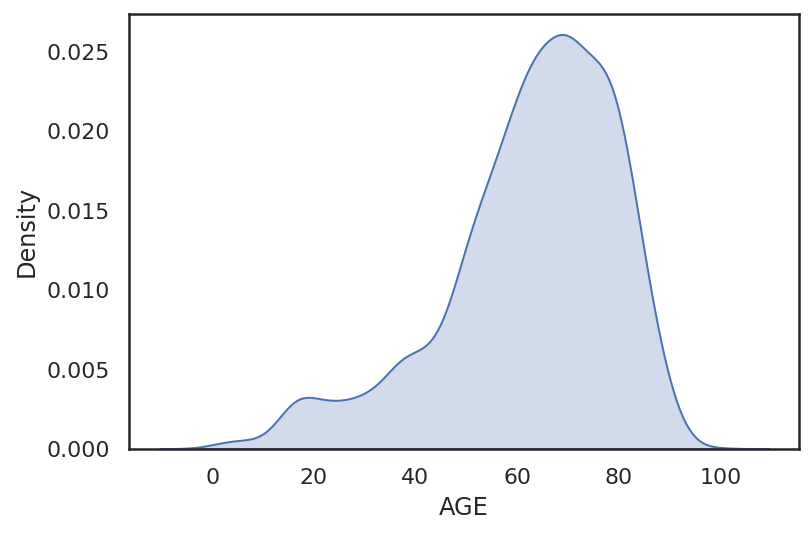

In [ ]:
sns.kdeplot(data['AGE'], shade=True)


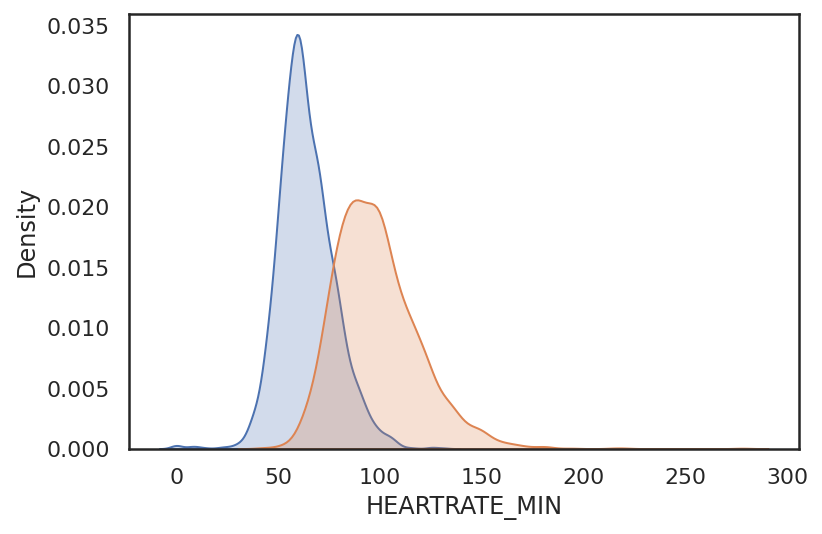

In [ ]:
sns.kdeplot(data['HEARTRATE_MIN'], shade=True)
sns.kdeplot(data['HEARTRATE_MAX'],shade=True)

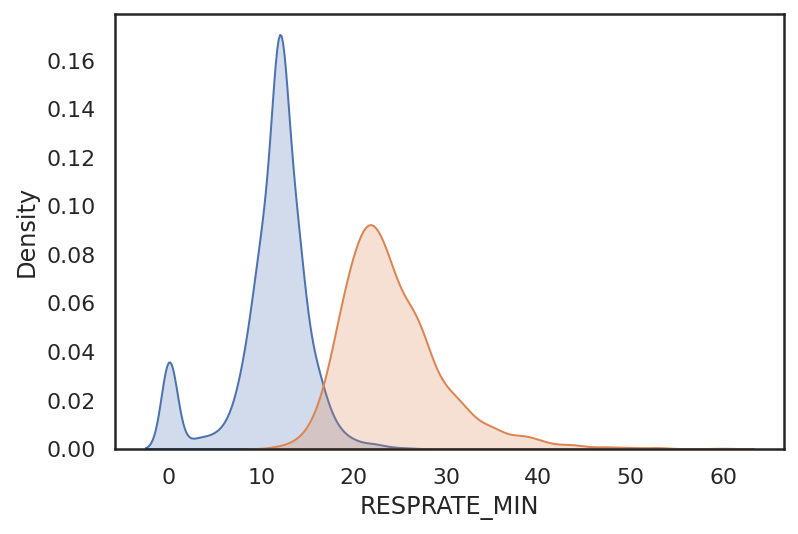

In [ ]:
sns.kdeplot(data['RESPRATE_MIN'], shade=True)
sns.kdeplot(data['RESPRATE_MAX'],shade=True)

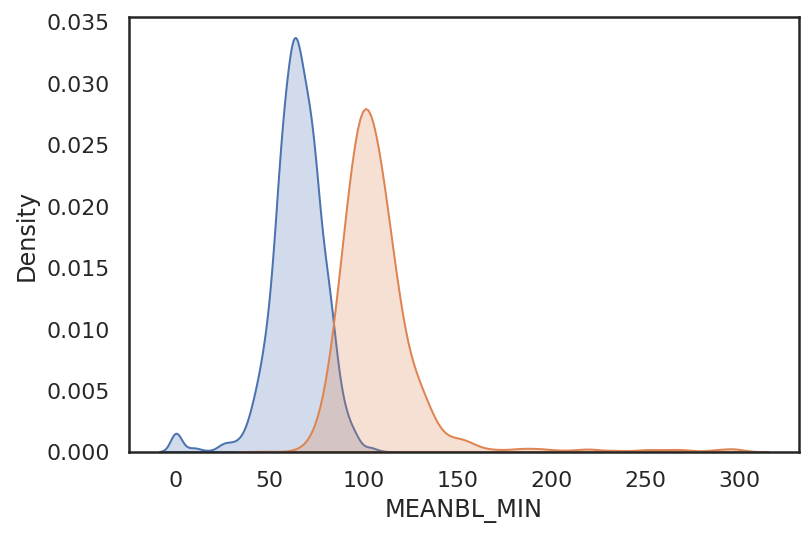

In [ ]:
sns.kdeplot(data['MEANBL_MIN'], shade=True)
sns.kdeplot(data['MEANBL_MAX'],shade=True)

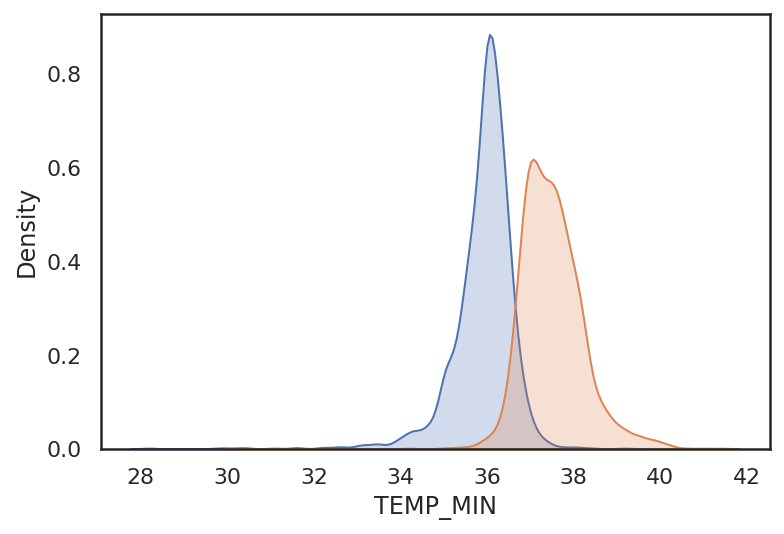

In [ ]:
sns.kdeplot(data['TEMP_MIN'], shade=True)
sns.kdeplot(data['TEMP_MAX'],shade=True)

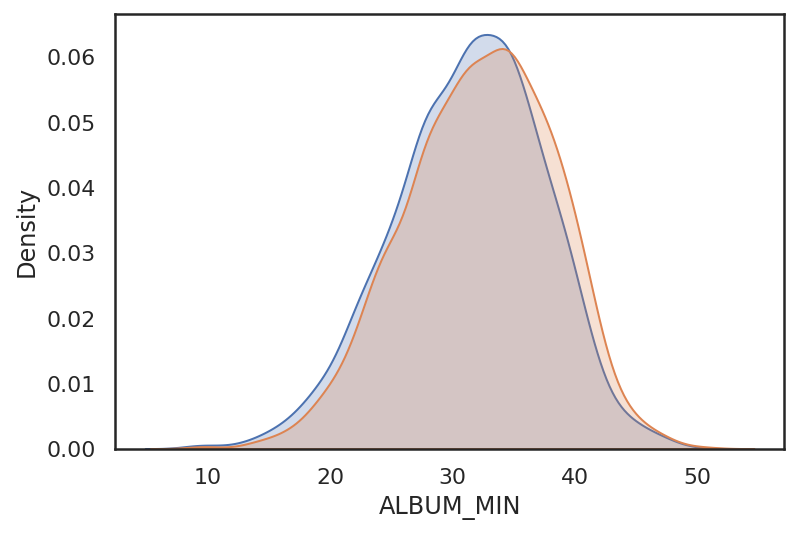

In [ ]:
sns.kdeplot(data['ALBUM_MIN'], shade=True)
sns.kdeplot(data['ALBUM_MAX'],shade=True)

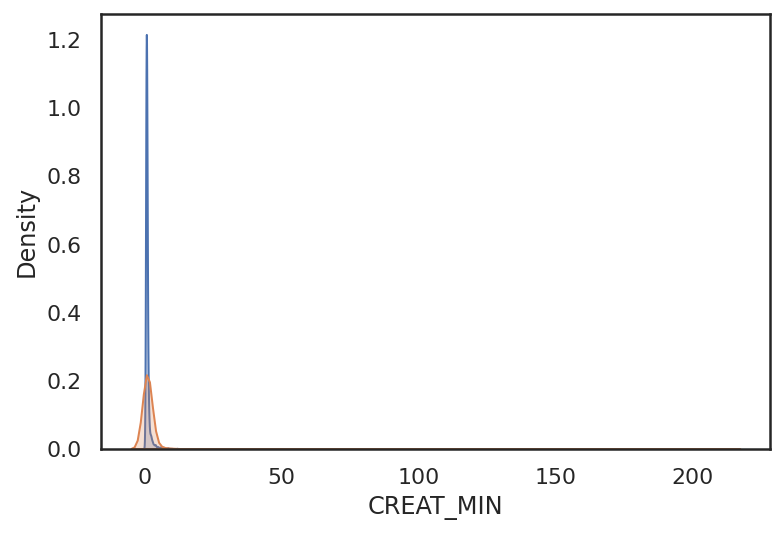

In [ ]:
sns.kdeplot(data['CREAT_MIN'], shade=True)
sns.kdeplot(data['CREAT_MAX'],shade=True)

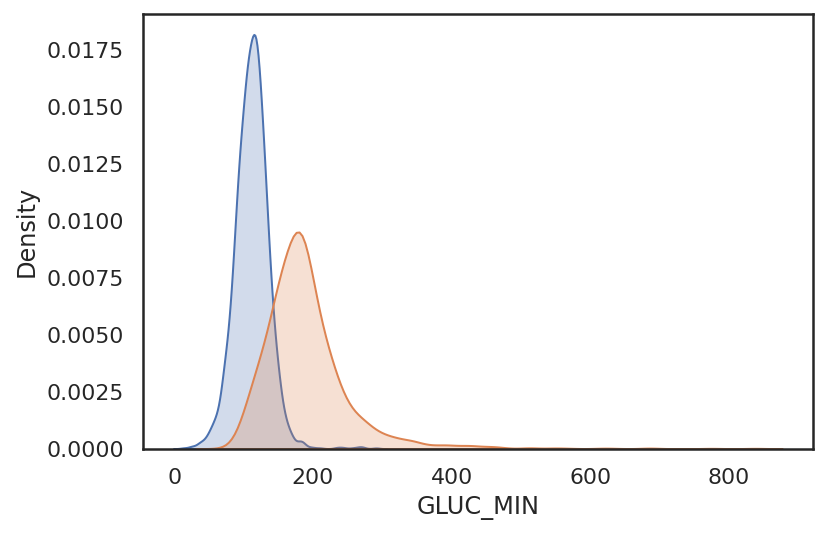

In [ ]:
sns.kdeplot(data['GLUC_MIN'], shade=True)
sns.kdeplot(data['GLUC_MAX'],shade=True)

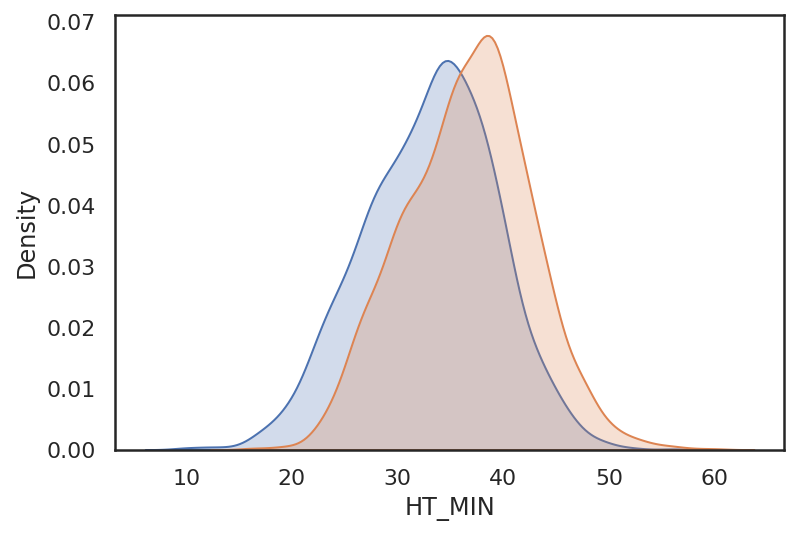

In [ ]:
sns.kdeplot(data['HT_MIN'], shade=True)
sns.kdeplot(data['HT_MAX'],shade=True)

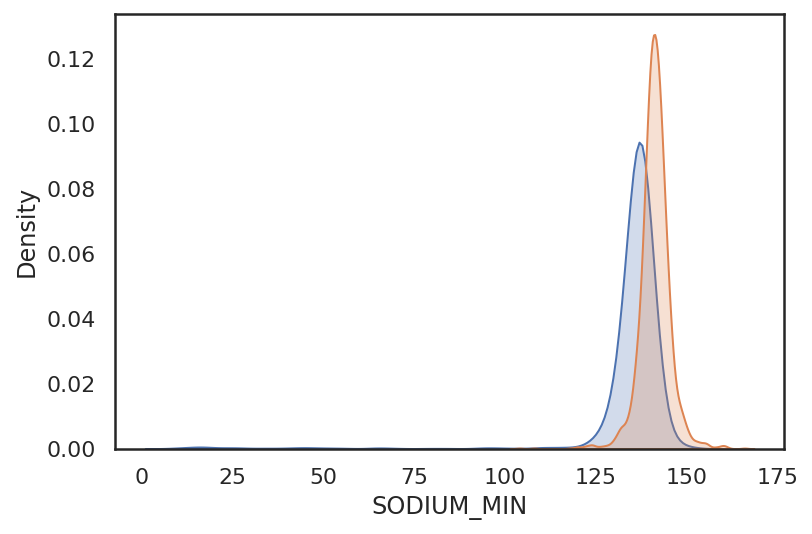

In [ ]:
sns.kdeplot(data['SODIUM_MIN'], shade=True)
sns.kdeplot(data['SODIUM_MAX'],shade=True)

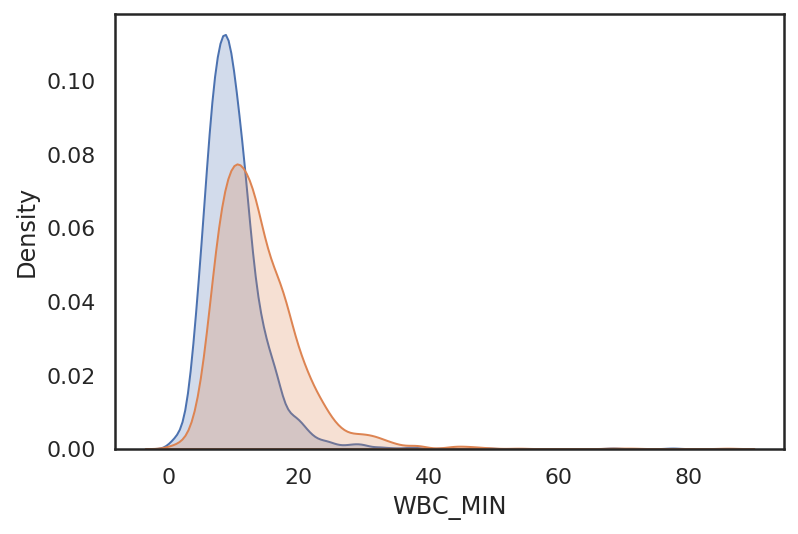

In [ ]:
sns.kdeplot(data['WBC_MIN'], shade=True)
sns.kdeplot(data['WBC_MAX'],shade=True)

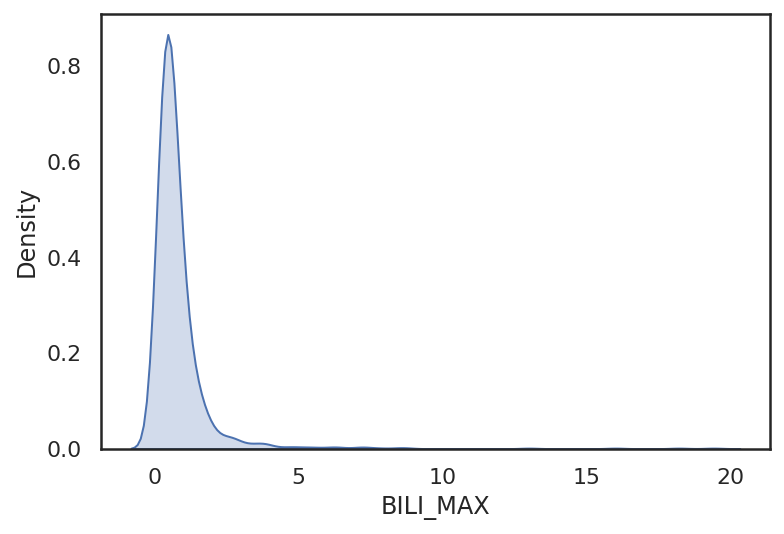

In [ ]:
sns.kdeplot(data['BILI_MAX'],shade=True)

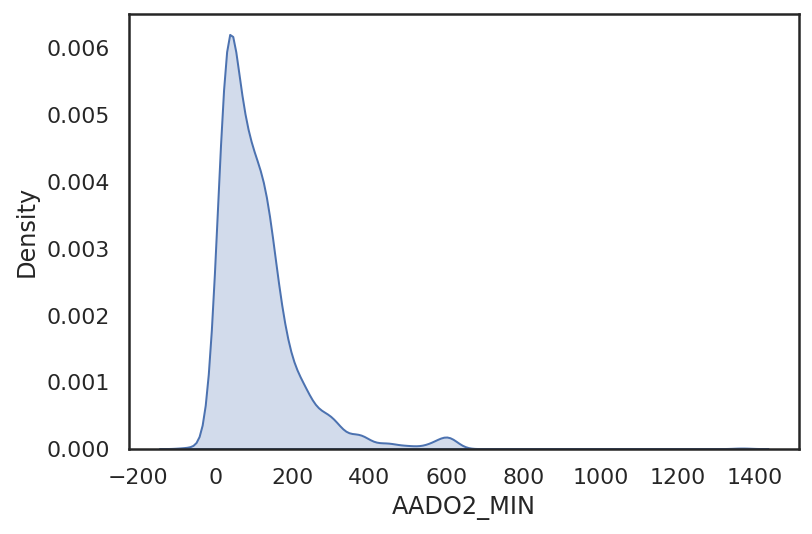

In [ ]:
sns.kdeplot(data['AADO2_MIN'], shade=True)

In [ ]:
data['FIO2_MAX']=data ['FIO2_MAX']<=100

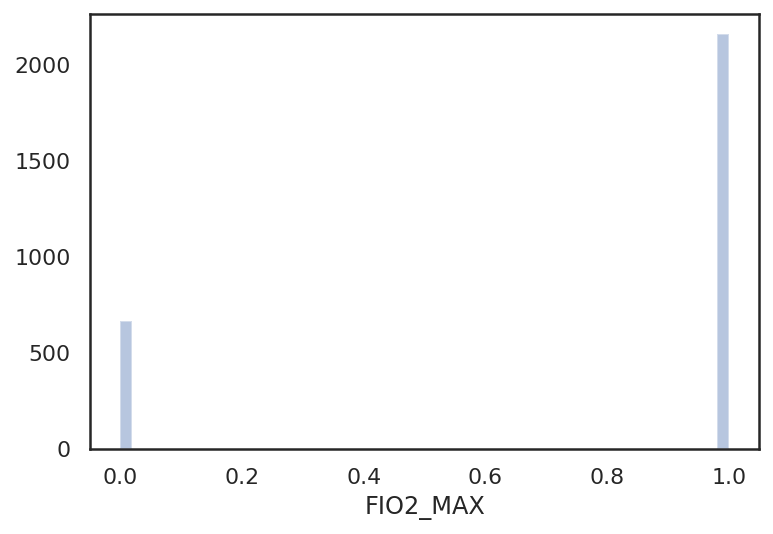

In [ ]:
sns.distplot(data['FIO2_MAX'], kde=False)

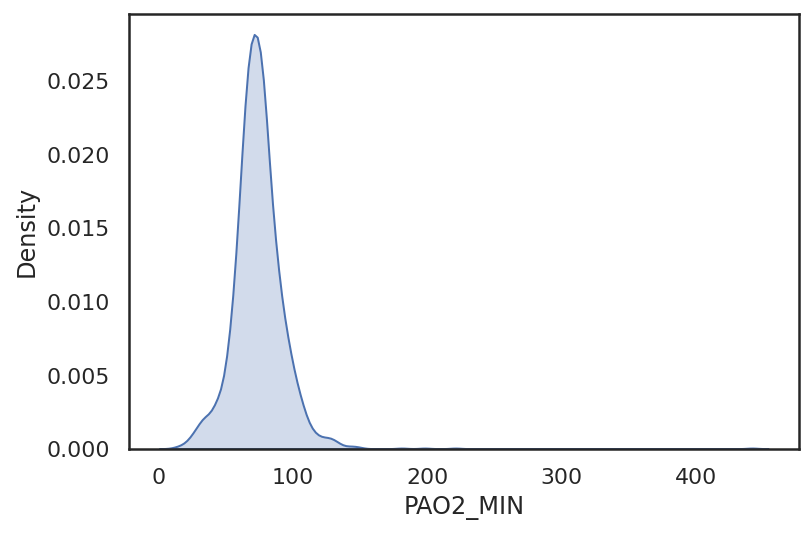

In [ ]:
sns.kdeplot(data['PAO2_MIN'], shade=True)

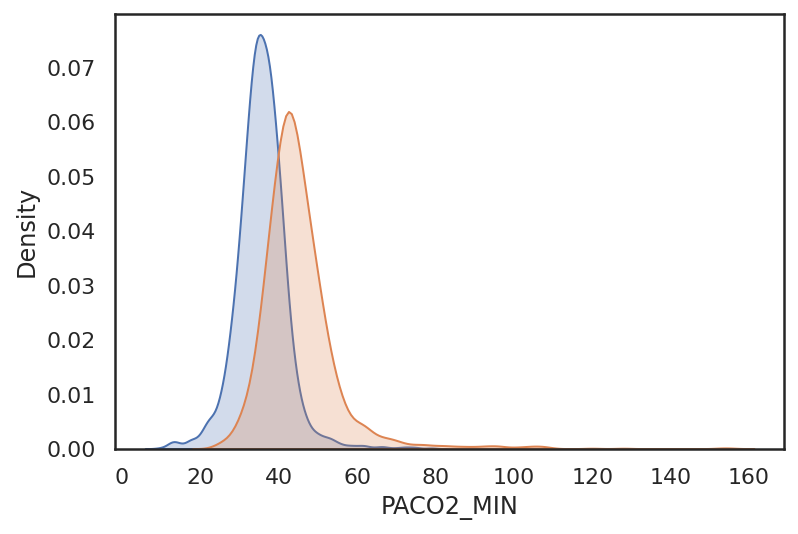

In [ ]:
sns.kdeplot(data['PACO2_MIN'], shade=True)
sns.kdeplot(data['PACO2_MAX'],shade=True)

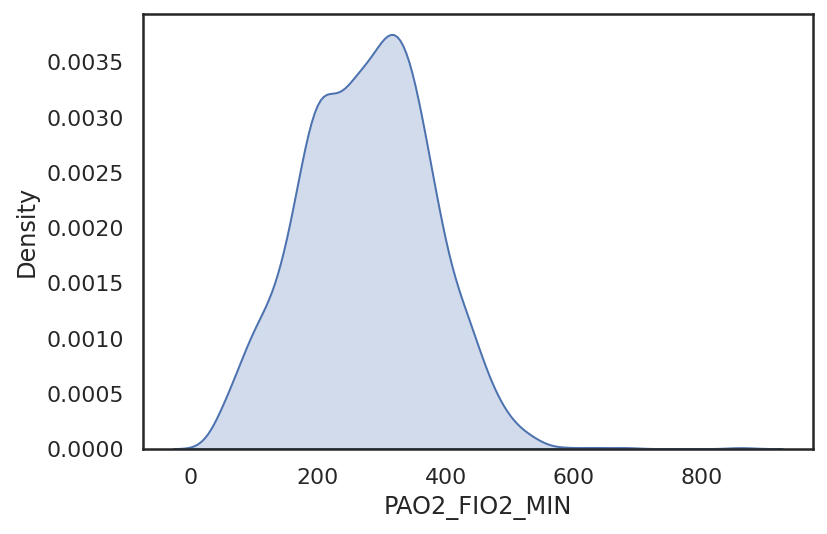

In [ ]:
sns.kdeplot(data['PAO2_FIO2_MIN'],shade=True)

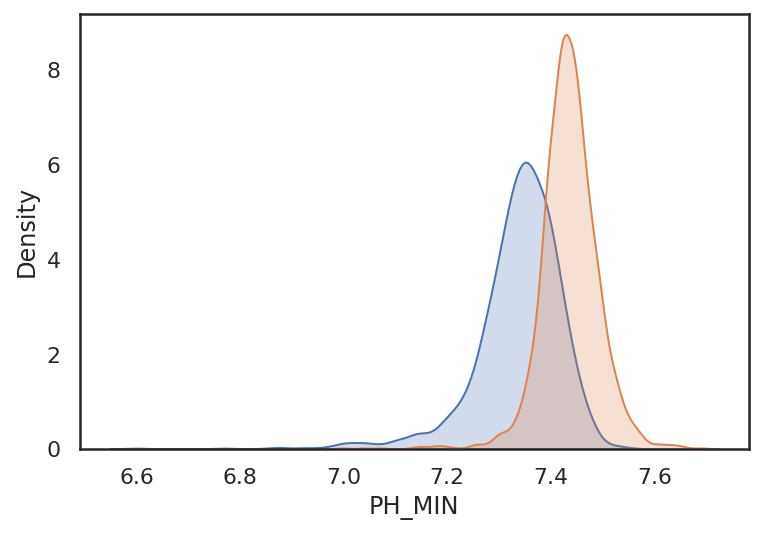

In [ ]:
sns.kdeplot(data['PH_MIN'], shade=True)
sns.kdeplot(data['PH_MAX'],shade=True)

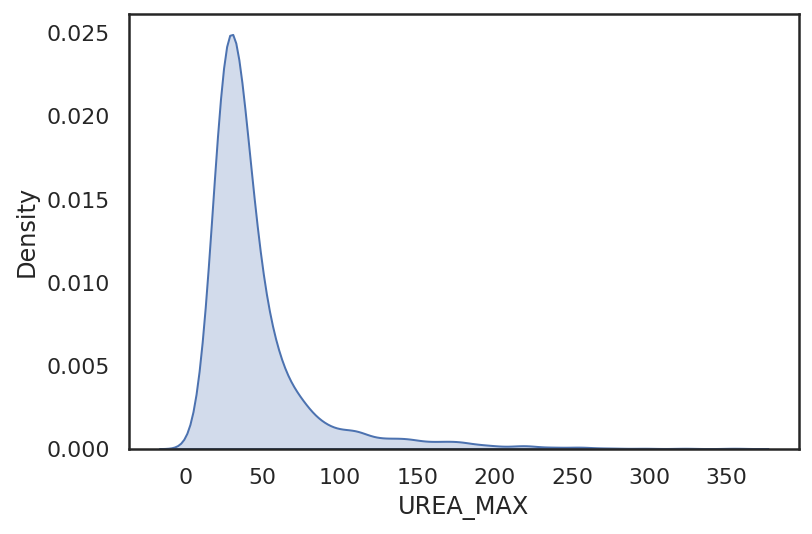

In [ ]:
sns.kdeplot(data['UREA_MAX'], shade=True)

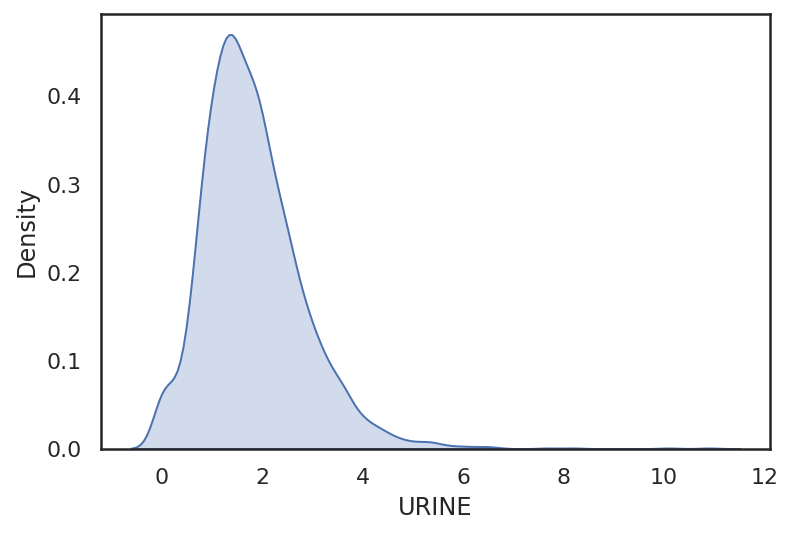

In [ ]:
sns.kdeplot(data['URINE'], shade=True)

In [ ]:
data['DATETIME_DIFF'] = DATETIME_DIFF
data

,ZHID,PATID,VISITID,UpdateTimestamp,MORTICU,MORT90D,DATETIME_START,DATETIME_END,AGE,ADMTYPE,ADMSOURCE,PRE_ICU_LOS,CABG,NB_GRAFTS,AIDS,CHRON_DIALYSIS,CIRRHOSIS,NEOPLASM_METAST,HEPATIC,HEM_MALIGN,LYMPHOMA,LEUKEMIA,MULTIPLE_MYELOMA,IMM_INSUF,MECH_VENTIL_24,EYE_LOW,MOTOR_LOW,VERBAL_LOW,EMV,HEARTRATE_MIN,HEARTRATE_MAX,RESPRATE_MIN,RESPRATE_MAX,MEANBL_MIN,MEANBL_MAX,TEMP_MIN,TEMP_MAX,ALBUM_MIN,ALBUM_MAX,CREAT_MIN,CREAT_MAX,GLUC_MIN,GLUC_MAX,HT_MIN,HT_MAX,SODIUM_MIN,SODIUM_MAX,WBC_MIN,WBC_MAX,AADO2_MIN,BILI_MAX,FIO2_MAX,PAO2_MIN,PACO2_MIN,PACO2_MAX,PAO2_FIO2_MIN,PH_MIN,PH_MAX,UREA_MAX,URINE,APACHE_DIAG_NR,APACHE_DIAG_CAT,SCORE_APACHE,PREDICTION,DATETIME_DIFF
0,BELG-ZOL,601049,12892358,2020-07-03 14:17:00,0,0,2019-01-01 05:07:00,2019-01-01 11:20:00,53,2,2.0,0.11,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,67,76.0,12.0,23.0,62,103.0,35.6,36.9,NaN,NaN,0.64,0.64,153.0,153.0,46.0,46.0,137.0,140.0,15.5,15.5,-77.4,0.9,True,181.0,36.9,36.9,861.90,7.47,7.47,13.0,2.5,299,gastrointestinal,23,1.2,0 days 06:13:00
1,BELG-ZOL,86824,12874187,2020-07-03 14:17:00,0,1,2019-01-01 12:59:00,2019-01-04 14:22:00,68,1,3.0,12.90,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,95,148.0,14.0,27.0,62,91.0,36.9,39.9,31.73,31.73,1.09,1.46,93.0,214.0,21.0,29.0,137.0,144.0,7.1,15.1,NaN,1.9,False,54.4,34.8,47.0,NaN,7.48,7.53,113.0,1.9,168,respiratory,78,42.3,3 days 01:23:00
2,BELG-ZOL,566517,12892419,2020-07-03 14:17:00,0,0,2019-01-01 18:38:00,2019-01-02 11:36:00,79,2,2.0,0.29,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,66,100.0,12.0,25.0,79,147.0,36.9,38.2,31.82,32.59,1.63,2.06,160.0,183.0,26.0,39.0,133.0,137.0,9.9,13.2,NaN,0.5,False,65.2,37.9,40.6,NaN,7.32,7.36,63.0,0.6,438,trauma,70,17.5,0 days 16:58:00
3,BELG-ZOL,860417,12892498,2020-07-03 14:17:00,0,1,2019-01-01 22:35:00,2019-01-03 14:19:00,65,2,3.0,0.12,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,4,14,74,101.0,9.0,20.0,86,213.0,36.4,37.2,NaN,NaN,0.67,1.02,121.0,153.0,34.0,36.0,140.0,143.0,6.8,8.3,NaN,0.3,False,65.5,34.9,40.5,NaN,7.39,7.45,27.0,1.9,366,neurologic,46,23.4,1 days 15:44:00
4,BELG-ZOL,105732,12892510,2020-07-03 14:17:00,0,0,2019-01-02 02:55:00,2019-01-08 12:23:00,36,2,3.0,0.20,0,0.0,0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,72,112.0,8.0,18.0,60,92.0,36.1,37.9,17.19,17.19,0.90,1.13,111.0,204.0,32.0,33.0,126.0,133.0,15.4,26.2,NaN,0.8,False,106.0,40.8,49.8,NaN,7.35,7.47,91.0,1.5,300,gastrointestinal,64,20.0,6 days 09:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,BELG-ZOL,429829,13638542,2020-07-03 14:17:00,0,1,2019-12-30 19:24:00,2020-01-07 14:23:00,80,1,4.0,8.90,0,0.0,0,0,0,0,0,0,0,0,0,0,0,4,6,5,15,78,108.0,13.0,39.0,52,89.0,35.5,37.4,NaN,NaN,0.88,1.14,86.0,304.0,25.0,27.0,99.0,133.0,14.3,19.2,242.5,1.2,True,42.2,33.9,48.1,139.00,7.36,7.48,63.0,2.5,168,respiratory,91,52.2,7 days 18:59:00
2812,BELG-ZOL,220901,13648604,2020-07-03 14:17:00,0,0,2019-12-31 00:27:00,2020-01-06 11:13:00,65,2,1.0,0.36,0,0.0,0,0,0,0,0,0,0,0,0,0,0,3,5,4,12,86,111.0,21.0,34.0,57,104.0,37.0,39.0,31.00,33.40,0.78,1.34,147.0,269.0,33.0,38.0,134.0,142.0,7.7,20.1,110.9,0.4,True,71.6,38.2,47.1,245.83,7.33,7.37,58.0,1.8,39,cardiovascular,74,9.1,6 days 10:46:00
2813,BELG-ZOL,75026,13648777,2020-07-03 14:17:00,0,0,2019-12-31 00:46:00,2020-01-07 11:04:00,68,1,3.0,0.24,0,0.0,0,0,0,0,0,0,0,0,0,0,0,2,5,3,10,72,128.0,13.0,30.0,60,108.0,36.0,39.2,NaN,NaN,0.73,0.74,110.0,195.0,39.0,42.0,136.0,142.0,13.3,15.6,229.4,0.8,True,57.9,32.2,46.4,173.60,7.31,7.47,43.0,1.6,18,cardiovascular,69,17.2,7 days 10:18:00
2814,BELG-ZOL,956131,13613098,2020-07-03 14:17:00,0,0,2019-12-31 12:26:00,2020-01-01 11:35:00,66,4,1.0,0.23,0,0.0,0,0,0,0,0,0,0,0,0,0,0,4,6,5,15,57,87.0,13.0,24.0,80,117.0,35.8,36.7,31.90,32.80,0.46,0.56,130.0,184.0,26.0,36.0,139.0,140.0,8.2,9.7,34.2,0.3,True,71.9,34.0,41.0,342.38,7.35,7.45,26.0,0.7,350,musculoskeletal/skin,48,2.1,0 days 23:09:00


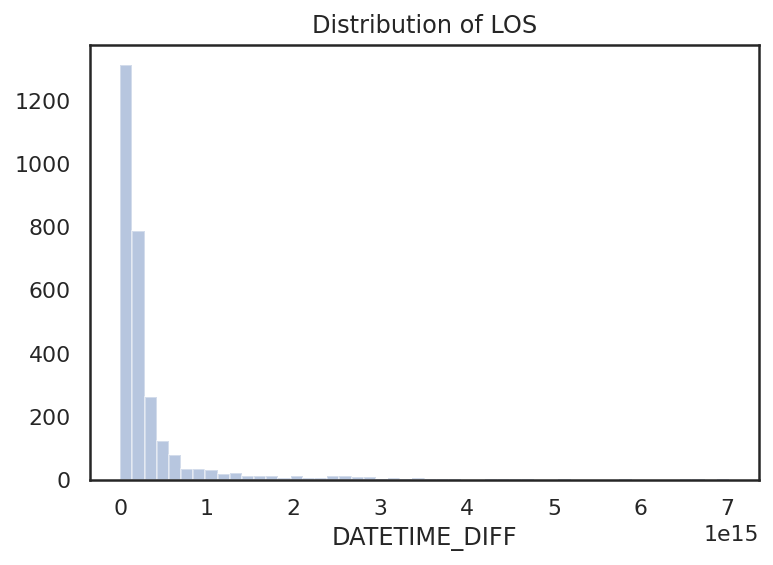

In [ ]:
sns.distplot(data['DATETIME_DIFF'],kde=False)
plt.title('Distribution of LOS')
plt.show()

In [ ]:
data.columns

Index(['ZHID', 'PATID', 'VISITID', 'UpdateTimestamp', 'MORTICU', 'MORT90D',
       'DATETIME_START', 'DATETIME_END', 'AGE', 'ADMTYPE', 'ADMSOURCE',
       'PRE_ICU_LOS', 'CABG', 'NB_GRAFTS', 'AIDS', 'CHRON_DIALYSIS',
       'CIRRHOSIS', 'NEOPLASM_METAST', 'HEPATIC', 'HEM_MALIGN', 'LYMPHOMA',
       'LEUKEMIA', 'MULTIPLE_MYELOMA', 'IMM_INSUF', 'MECH_VENTIL_24',
       'EYE_LOW', 'MOTOR_LOW', 'VERBAL_LOW', 'EMV', 'HEARTRATE_MIN',
       'HEARTRATE_MAX', 'RESPRATE_MIN', 'RESPRATE_MAX', 'MEANBL_MIN',
       'MEANBL_MAX', 'TEMP_MIN', 'TEMP_MAX', 'ALBUM_MIN', 'ALBUM_MAX',
       'CREAT_MIN', 'CREAT_MAX', 'GLUC_MIN', 'GLUC_MAX', 'HT_MIN', 'HT_MAX',
       'SODIUM_MIN', 'SODIUM_MAX', 'WBC_MIN', 'WBC_MAX', 'AADO2_MIN',
       'BILI_MAX', 'FIO2_MAX', 'PAO2_MIN', 'PACO2_MIN', 'PACO2_MAX',
       'PAO2_FIO2_MIN', 'PH_MIN', 'PH_MAX', 'UREA_MAX', 'URINE',
       'APACHE_DIAG_NR', 'APACHE_DIAG_CAT', 'SCORE_APACHE', 'PREDICTION',
       'DATETIME_DIFF'],
      dtype='object')

In [ ]:
data.drop('AIDS', inplace=True, axis=1)

In [ ]:
data.describe()

,PATID,VISITID,MORTICU,MORT90D,AGE,ADMTYPE,ADMSOURCE,PRE_ICU_LOS,CABG,NB_GRAFTS,CHRON_DIALYSIS,CIRRHOSIS,NEOPLASM_METAST,HEPATIC,HEM_MALIGN,LYMPHOMA,LEUKEMIA,MULTIPLE_MYELOMA,IMM_INSUF,MECH_VENTIL_24,EYE_LOW,MOTOR_LOW,VERBAL_LOW,EMV,HEARTRATE_MIN,HEARTRATE_MAX,RESPRATE_MIN,RESPRATE_MAX,MEANBL_MIN,MEANBL_MAX,TEMP_MIN,TEMP_MAX,ALBUM_MIN,ALBUM_MAX,CREAT_MIN,CREAT_MAX,GLUC_MIN,GLUC_MAX,HT_MIN,HT_MAX,SODIUM_MIN,SODIUM_MAX,WBC_MIN,WBC_MAX,AADO2_MIN,BILI_MAX,PAO2_MIN,PACO2_MIN,PACO2_MAX,PAO2_FIO2_MIN,PH_MIN,PH_MAX,UREA_MAX,URINE,APACHE_DIAG_NR,SCORE_APACHE,PREDICTION,DATETIME_DIFF
count,2816.000000,2.816000e+03,2816.000000,2816.000000,2816.00000,2816.000000,2791.000000,2816.000000,2816.000000,2808.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2815.000000,2815.000000,2813.000000,2816.000000,2815.000000,2809.000000,2807.000000,1965.000000,1967.000000,2676.000000,2689.000000,2620.000000,2623.000000,2713.000000,2724.000000,2739.000000,2742.000000,2708.000000,2720.000000,2141.000000,1242.000000,2614.000000,2615.00000,2615.000000,2171.000000,2615.000000,2615.000000,2685.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816
mean,443279.104403,1.324757e+07,0.051136,0.109375,62.65767,2.756392,2.340021,2.451371,0.110440,0.332977,0.011009,0.012784,0.048295,0.017045,0.019176,0.009233,0.004972,0.002841,0.054688,0.666903,3.783381,5.727983,4.611506,14.101207,63.746094,98.213499,11.065364,24.131532,64.479048,107.707282,35.908758,37.494051,31.329359,32.203198,1.000321,1.876162,111.574427,189.377430,33.010321,36.549927,134.937568,141.198031,9.999557,13.751287,109.356235,0.825845,73.734468,35.58826,45.101721,275.859180,7.338516,7.435836,45.084544,1.813920,243.206321,55.730114,13.861683,3 days 18:29:46.342329545
std,332651.786557,2.245235e+05,0.220315,0.312165,16.94249,1.386164,2.304921,12.202211,0.313493,1.032025,0.104361,0.112362,0.214428,0.129464,0.137168,0.095661,0.070347,0.053234,0.227410,0.471404,0.679008,0.984360,1.028370,2.585803,13.645622,20.623531,4.206468,5.451432,14.050793,24.703248,0.695202,0.710719,6.112677,6.071021,0.868249,8.191335,24.342695,62.185871,6.268563,5.988550,13.189886,4.184432,4.764142,6.515280,104.146164,1.258493,19.138495,6.33540,10.063545,99.746326,0.082034,0.055340,35.222117,1.000613,112.675546,23.207542,18.255523,6 days 19:21:44.353499822
min,267.000000,1.190510e+07,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,43.000000,0.000000,12.000000,0.000000,48.000000,28.200000,30.400000,8.900000,9.300000,0.170000,0.230000,14.000000,70.000000,10.000000,16.000000,9.000000,104.000000,0.400000,0.400000,-77.400000,0.100000,12.200000,9.90000,24.300000,38.380000,6.600000,7.000000,5.000000,0.000000,1.000000,0.000000,0.100000,0 days 00:06:00
25%,137097.750000,1.305672e+07,0.000000,0.000000,54.00000,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,55.000000,84.000000,10.000000,20.000000,57.000000,95.000000,35.600000,37.000000,27.300000,28.000000,0.630000,0.740000,97.000000,153.000000,29.000000,32.000000,135.000000,139.000000,7.000000,9.400000,37.900000,0.300000,63.900000,32.10000,39.600000,203.130000,7.300000,7.400000,26.000000,1.100000,161.000000,40.000000,2.300000,0 days 22:14:00
50%,366478.500000,1.324870e+07,0.000000,0.000000,65.00000,4.000000,1.000000,0.890000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,6.000000,5.000000,15.000000,62.000000,96.000000,12.000000,23.000000,65.000000,104.000000,36.000000,37.400000,31.700000,32.500000,0.790000,0.930000,112.000000,180.000000,34.000000,37.000000,137.000000,141.000000,9.200000,12.600000,83.600000,0.5

In [ ]:
pd.set_option('display.max_rows', 120)
data.isnull().sum()

ZHID                   0
PATID                  0
VISITID                0
UpdateTimestamp        0
MORTICU                0
MORT90D                0
DATETIME_START         0
DATETIME_END           0
AGE                    0
ADMTYPE                0
ADMSOURCE             25
PRE_ICU_LOS            0
CABG                   0
NB_GRAFTS              8
CHRON_DIALYSIS         0
CIRRHOSIS              0
NEOPLASM_METAST        0
HEPATIC                0
HEM_MALIGN             0
LYMPHOMA               0
LEUKEMIA               0
MULTIPLE_MYELOMA       0
IMM_INSUF              0
MECH_VENTIL_24         0
EYE_LOW                0
MOTOR_LOW              0
VERBAL_LOW             0
EMV                    0
HEARTRATE_MIN          0
HEARTRATE_MAX          1
RESPRATE_MIN           1
RESPRATE_MAX           3
MEANBL_MIN             0
MEANBL_MAX             1
TEMP_MIN               7
TEMP_MAX               9
ALBUM_MIN            851
ALBUM_MAX            849
CREAT_MIN            140
CREAT_MAX            127


In [ ]:
data.corr()

,PATID,VISITID,MORTICU,MORT90D,AGE,ADMTYPE,ADMSOURCE,PRE_ICU_LOS,CABG,NB_GRAFTS,CHRON_DIALYSIS,CIRRHOSIS,NEOPLASM_METAST,HEPATIC,HEM_MALIGN,LYMPHOMA,LEUKEMIA,MULTIPLE_MYELOMA,IMM_INSUF,MECH_VENTIL_24,EYE_LOW,MOTOR_LOW,VERBAL_LOW,EMV,HEARTRATE_MIN,HEARTRATE_MAX,RESPRATE_MIN,RESPRATE_MAX,MEANBL_MIN,MEANBL_MAX,TEMP_MIN,TEMP_MAX,ALBUM_MIN,ALBUM_MAX,CREAT_MIN,CREAT_MAX,GLUC_MIN,GLUC_MAX,HT_MIN,HT_MAX,SODIUM_MIN,SODIUM_MAX,WBC_MIN,WBC_MAX,AADO2_MIN,BILI_MAX,FIO2_MAX,PAO2_MIN,PACO2_MIN,PACO2_MAX,PAO2_FIO2_MIN,PH_MIN,PH_MAX,UREA_MAX,URINE,APACHE_DIAG_NR,SCORE_APACHE,PREDICTION
PATID,1.000000,0.019651,-0.030809,-0.067747,-0.258433,0.132397,0.025804,-0.027821,0.002304,0.007297,-0.034047,-0.037308,0.009240,-0.064399,-0.046029,-0.031875,-0.029238,-0.003364,-0.040233,0.076913,-0.034830,-0.034376,-0.002074,-0.023240,-0.024110,-0.036803,-0.026889,-0.110241,0.064095,-0.036690,0.015886,-0.035150,0.069115,0.059746,-0.085809,-0.036450,0.048211,-0.094897,0.061954,0.036691,0.075432,0.041663,-0.031215,-0.031820,-0.053864,-0.019913,-0.033370,0.101569,-0.029376,-0.064083,0.111680,0.025291,-0.047900,-0.137623,0.070283,0.168942,-0.191212,-0.123552
VISITID,0.019651,1.000000,-0.012319,0.019400,0.015971,-0.044417,0.082162,-0.126901,-0.016382,-0.001878,0.000080,0.022991,0.013599,-0.079730,0.032455,0.017920,0.026697,0.005501,0.030728,-0.031334,-0.008078,-0.002150,-0.019786,-0.005941,-0.040117,-0.005467,-0.005198,0.009598,0.010074,0.017455,-0.035020,-0.053056,-0.014907,-0.009623,-0.037889,-0.027939,-0.023188,0.029289,-0.012944,-0.002449,-0.023441,-0.056488,-0.018026,-0.028352,-0.085372,-0.035155,0.319454,0.028917,-0.047097,-0.055088,0.088411,0.031834,0.036071,-0.007173,-0.013336,-0.033509,0.012457,0.005230
MORTICU,-0.030809,-0.012319,1.000000,0.662447,0.122512,-0.220920,0.129206,0.013711,-0.050937,-0.046862,0.021859,0.030983,0.030420,0.056612,0.026315,0.028157,0.006512,0.017898,0.128513,0.006724,-0.339119,-0.368279,-0.352875,-0.373250,0.061984,0.123808,0.042015,0.079923,-0.172592,0.011304,-0.211925,-0.043292,-0.104157,-0.092221,0.136460,0.006142,0.004532,0.088885,-0.066536,-0.040816,0.021086,0.068489,0.034051,0.023872,0.208708,0.082770,-0.068993,0.001446,-0.077028,0.047507,-0.142073,-0.179396,-0.087796,0.206568,-0.112969,-0.182395,0.431103,0.520986
MORT90D,-0.067747,0.019400,0.662447,1.000000,0.208988,-0.262682,0.161914,0.050340,-0.083547,-0.081239,0.061167,0.041145,0.085577,0.094493,0.033963,0.037547,0.007583,0.024049,0.145902,-0.037191,-0.288736,-0.314704,-0.327933,-0.326183,0.084497,0.148640,0.058411,0.147777,-0.191102,0.004200,-0.194176,-0.035740,-0.134818,-0.114913,0.169764,0.039709,-0.089884,0.127550,-0.116908,-0.103432,-0.012207,0.021067,0.043541,0.033290,0.165059,0.099088,-0.028424,-0.037461,-0.069275,0.073528,-0.127009,-0.147397,-0.028204,0.269664,-0.151587,-0.199919,0.483837,0.578952
AGE,-0.258433,0.015971,0.122512,0.208988,1.000000,0.037894,-0.025704,0.034970,0.112060,0.100600,0.028050,-0.009270,0.032714,-0.019041,0.078491,0.062665,0.027360,0.014470,0.027634,0.024681,0.051296,0.035290,0.027087,0.038545,-0.078999,-0.125401,-0.086282,0.067960,-0.198181,0.054171,-0.156954,-0.119132,-0.188518,-0.183344,0.151964,0.042537,-0.004864,0.169676,-0.197710,-0.186333,-0.048969,-0.041233,-0.007080,0.021263,0.126666,0.030910,0.213683,-0.151058,-0.013581,0.051851,-0.199963,-0.041532,0.048278,0.301024,-0.134132,-0.146923,0.477917,0.287884
ADMTYPE,0.132397,-0.044417,-0.220920,-0.262682,0.037894,1.000000,-0.517659,-0.018876,0.267122,0.243258,-0.028113,-0.089476,0.052743,-0.093645,-0.010921,-0.009822,0.019711,-0.014689,-0.067035,0.505313,0.309263,0.281018,0.359228,0.334831,-0.151283,-0.242625,-0.311733,-0.260998,0.112857,-0.083138,0.037843,-0.147958,-0.032740,-0.032368,-0.161352,-0.096338,0.209188,-0.068967,-0.015546,-0.060761,0.159420,0.078846,0.017658,0.060037,-0.061967,0.039785,0.104976,0.156133,0.113972,-0.008494,0.067495,-0.048359,-0.153551,-0.260903,0.085761,0.659384,-0.388751,-0.495572
ADMSOURCE,0.025804,0.082162,0.129206,0.161914,-0.025704,-0.517659,1.000000,

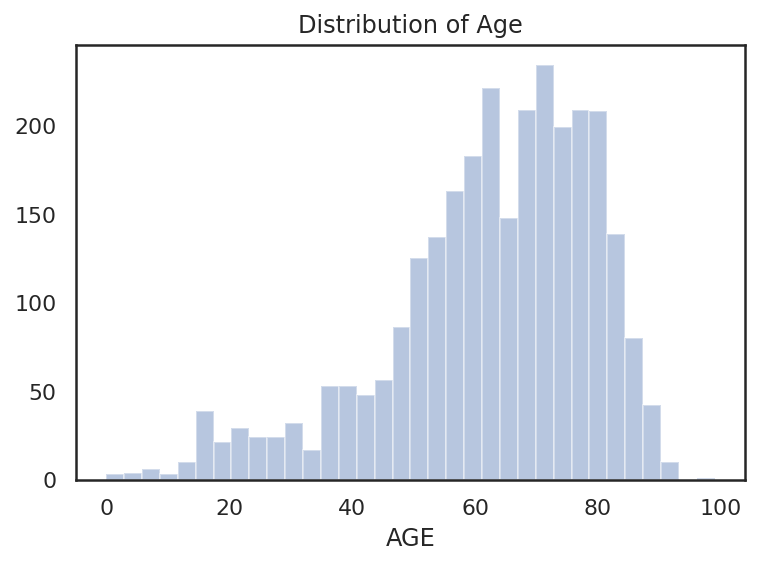

In [ ]:
sns.distplot(data['AGE'],kde=False)
plt.title('Distribution of Age')
plt.show()

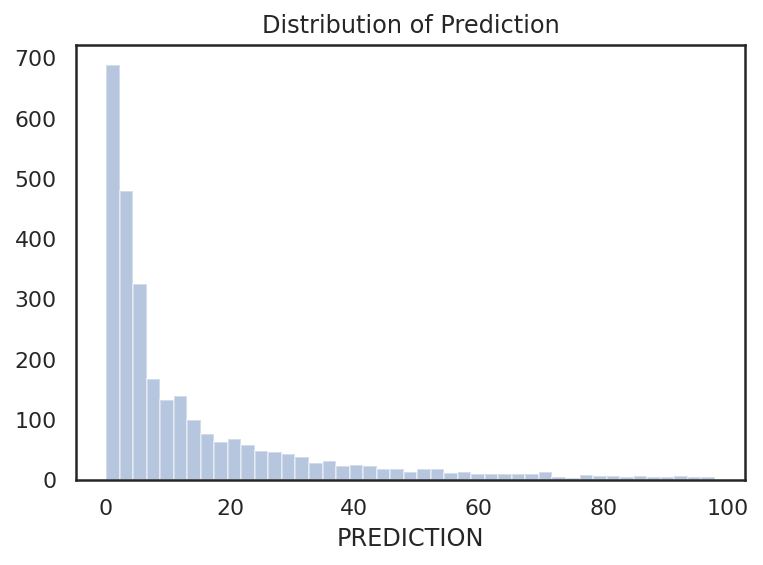

In [ ]:
sns.distplot(data['PREDICTION'],kde=False)
plt.title('Distribution of Prediction')
plt.show()

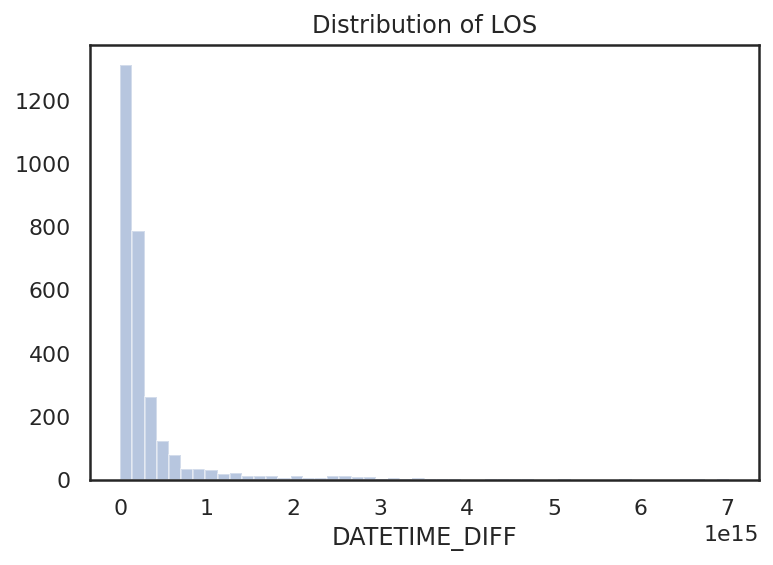

In [ ]:
sns.distplot(data['DATETIME_DIFF'],kde=False)
plt.title('Distribution of LOS')
plt.show()

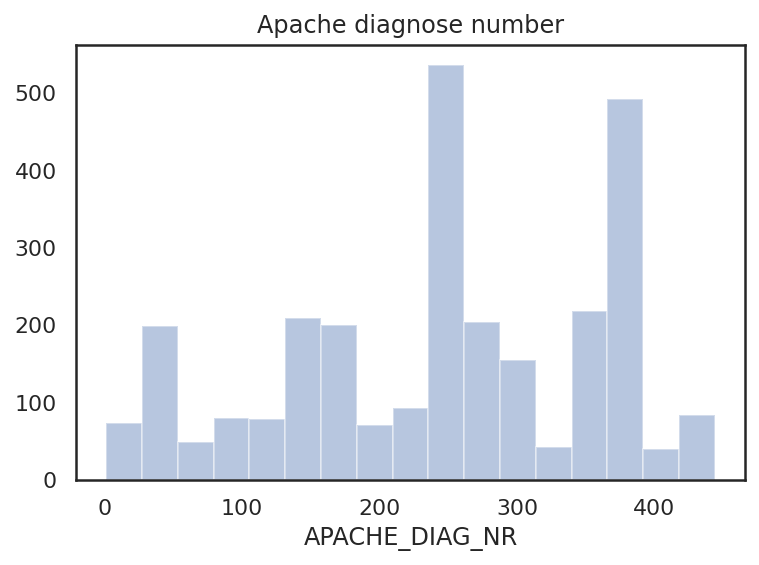

In [ ]:
sns.distplot(data['APACHE_DIAG_NR'],kde=False)
plt.title('Apache diagnose number')
plt.show()

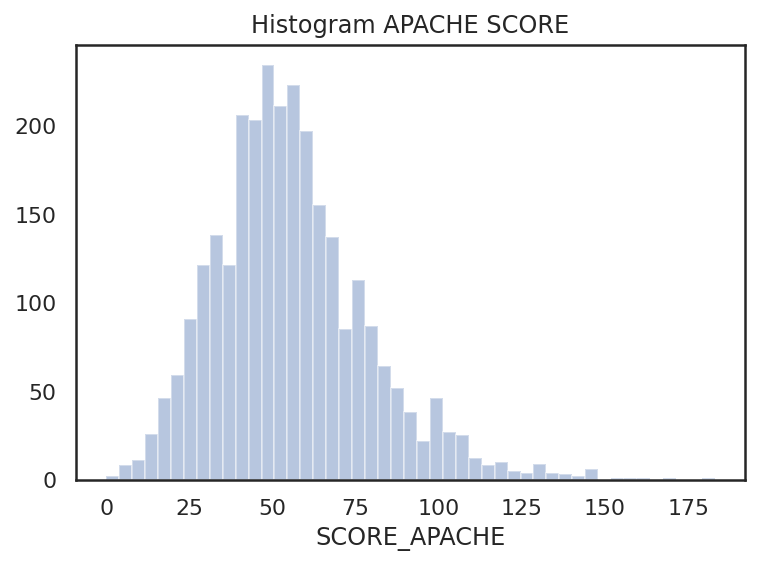

In [ ]:
sns.distplot(data['SCORE_APACHE'],kde=False)
plt.title('Histogram APACHE SCORE')
plt.show()

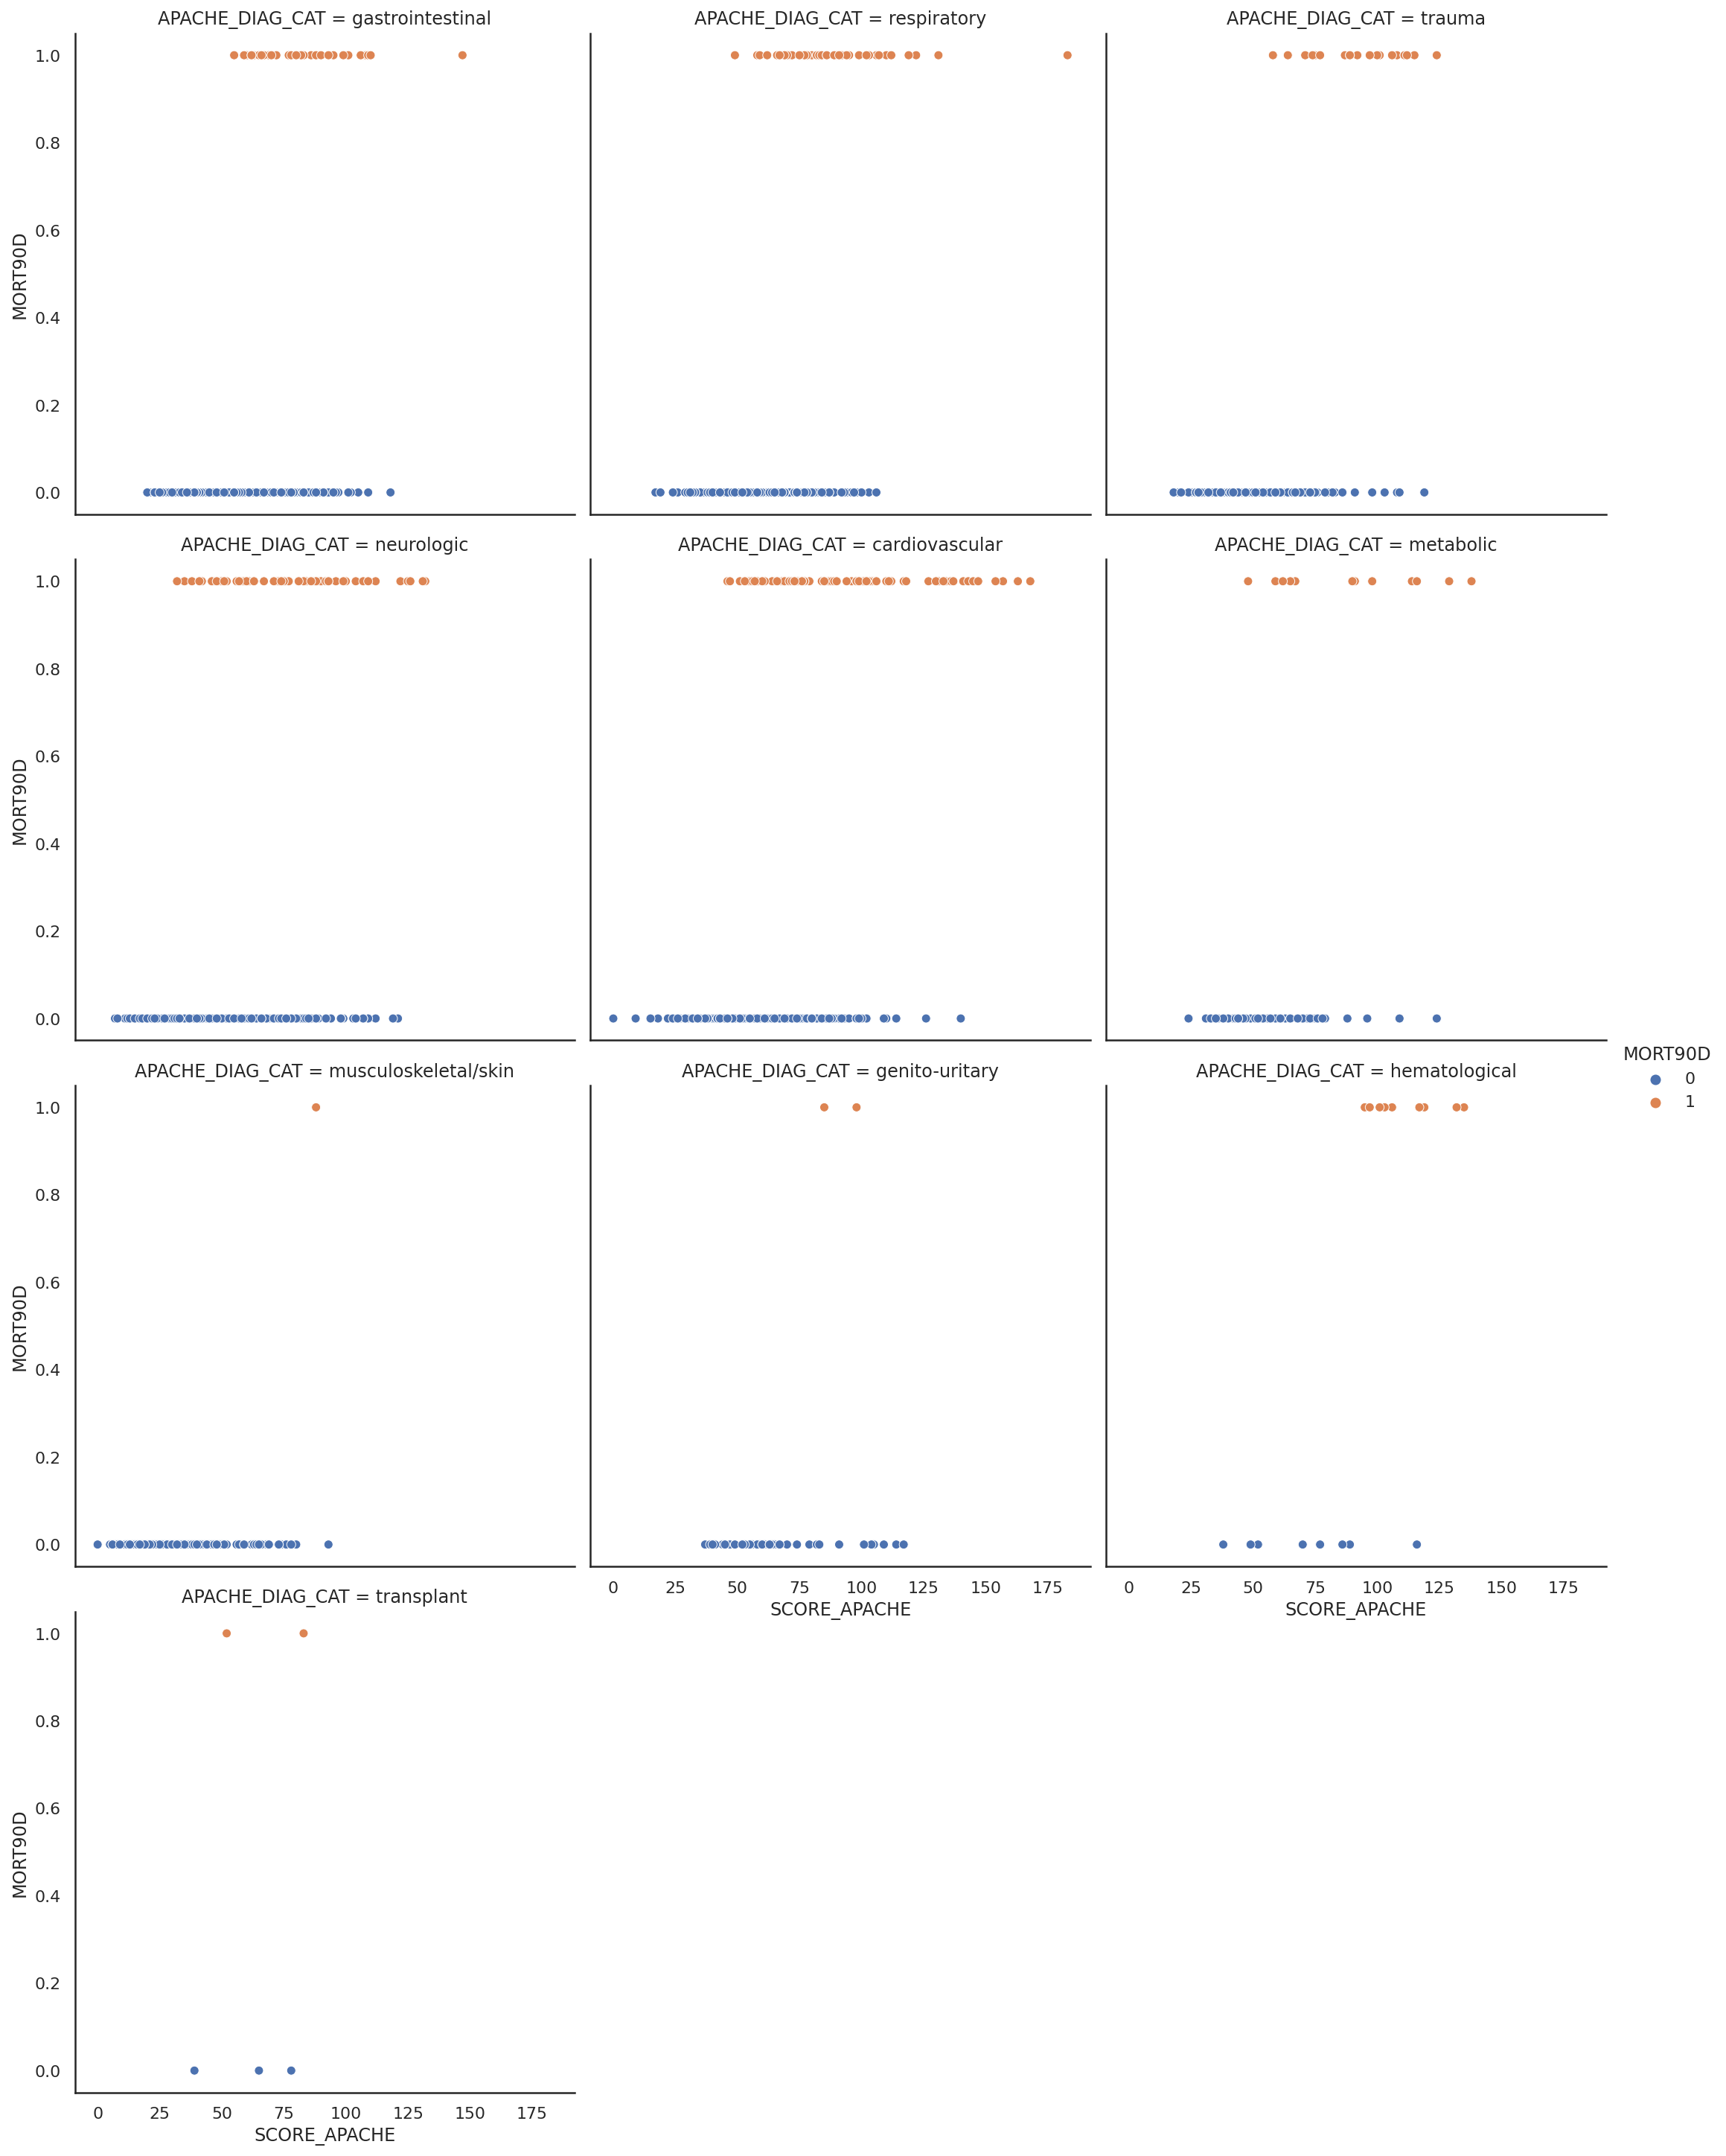

In [ ]:
sns.relplot(x="SCORE_APACHE", y="MORT90D",col='APACHE_DIAG_CAT',col_wrap=3,hue="MORT90D", data=data);

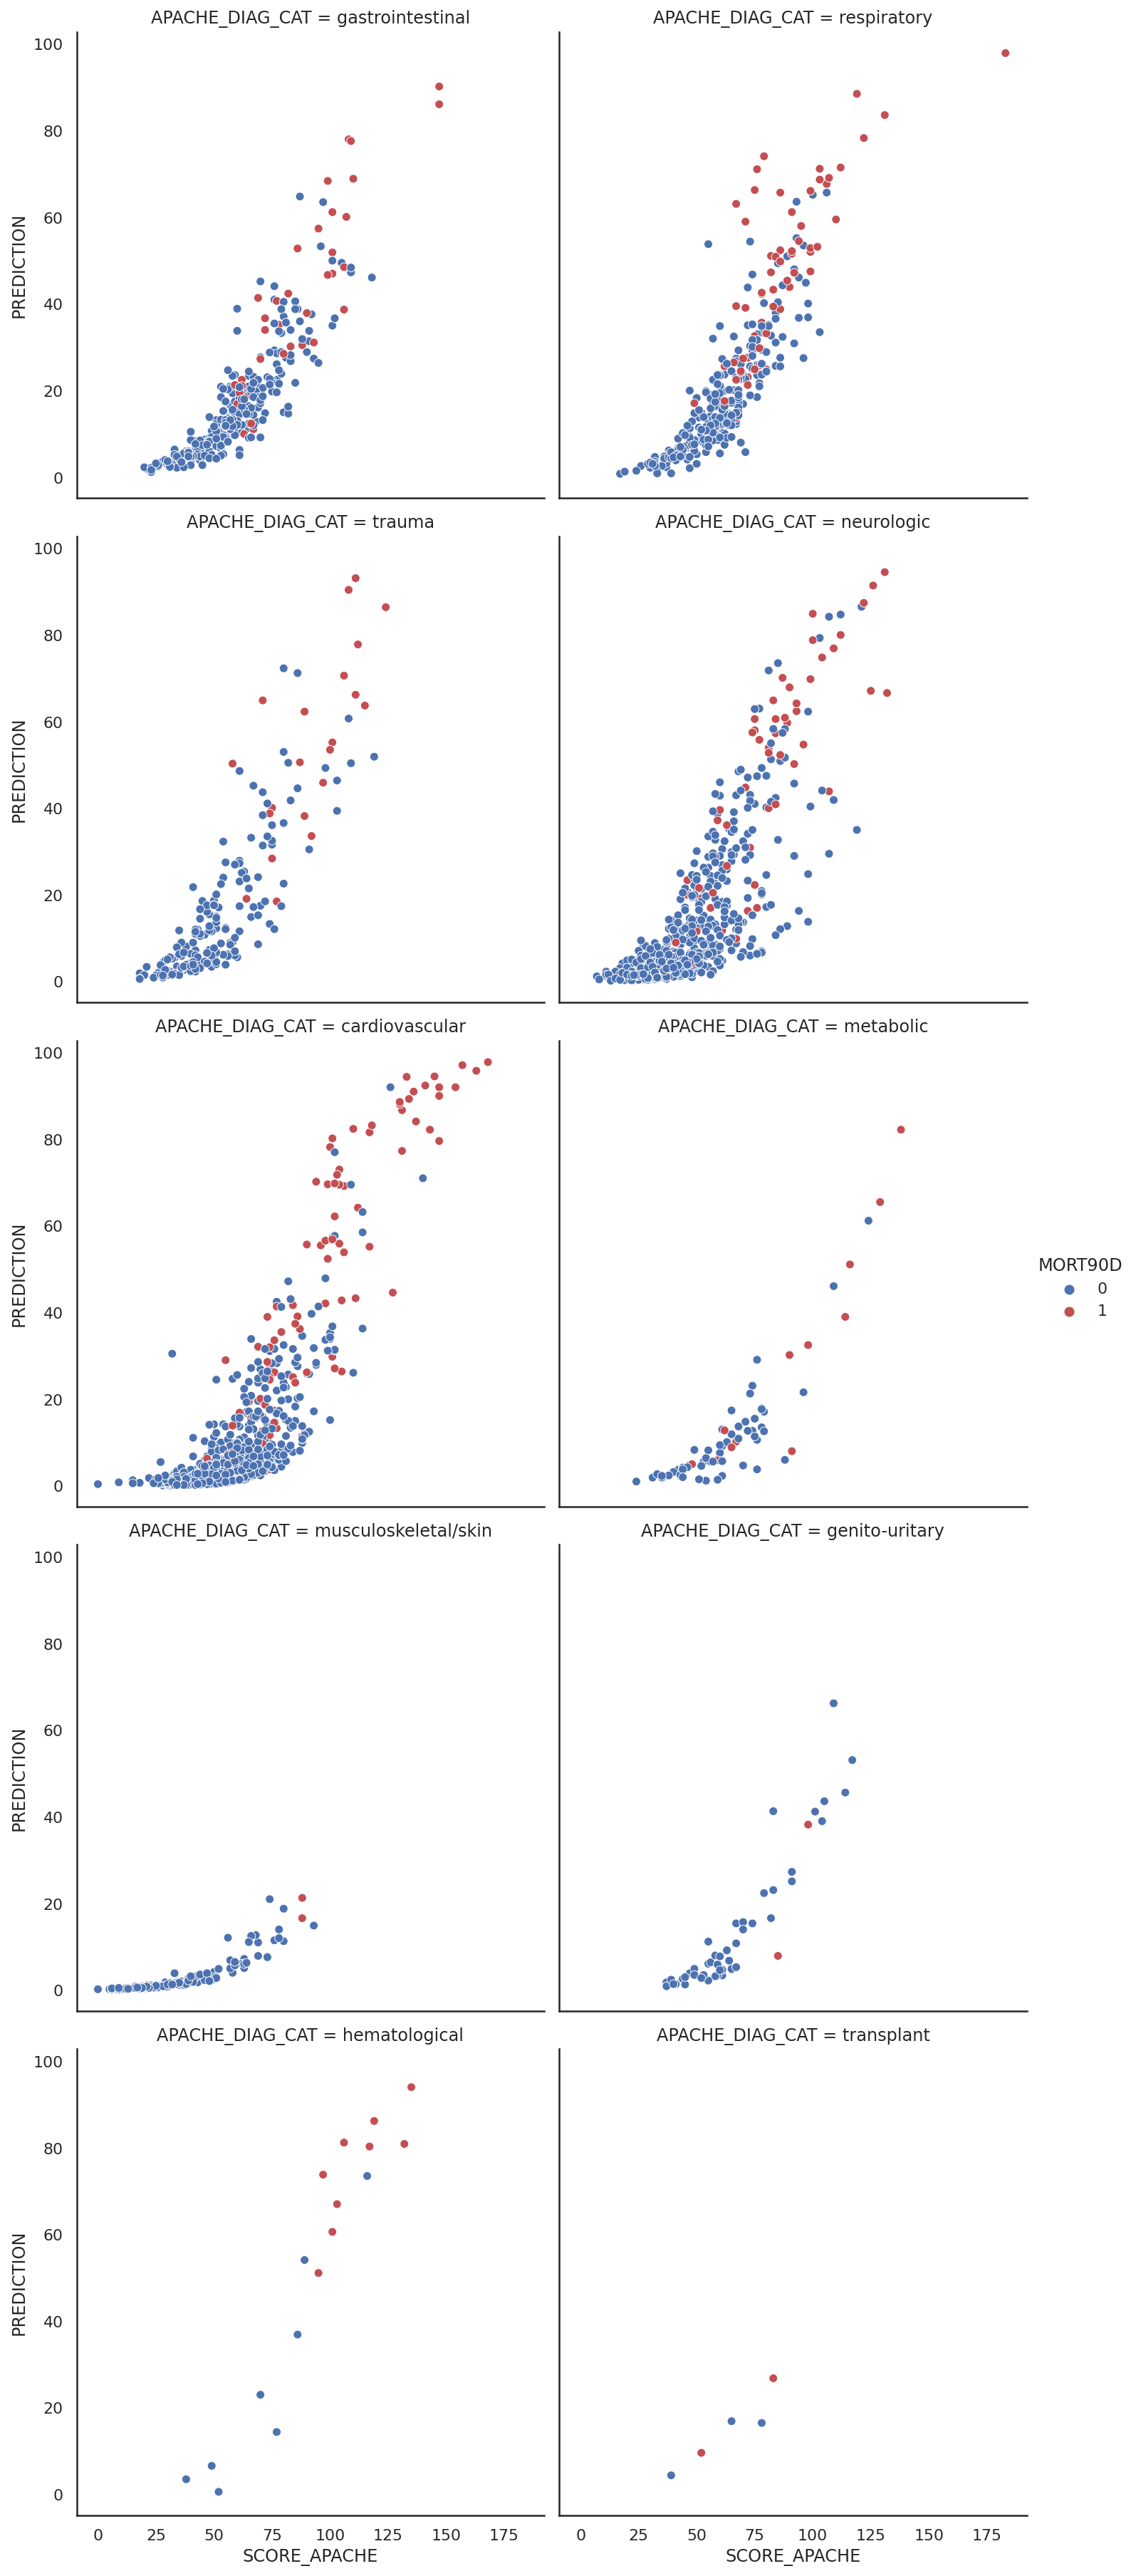

In [ ]:
sns.relplot(x="SCORE_APACHE", y="PREDICTION",col='APACHE_DIAG_CAT',col_wrap=2,hue="MORT90D",palette=["b", "r"],data=data);

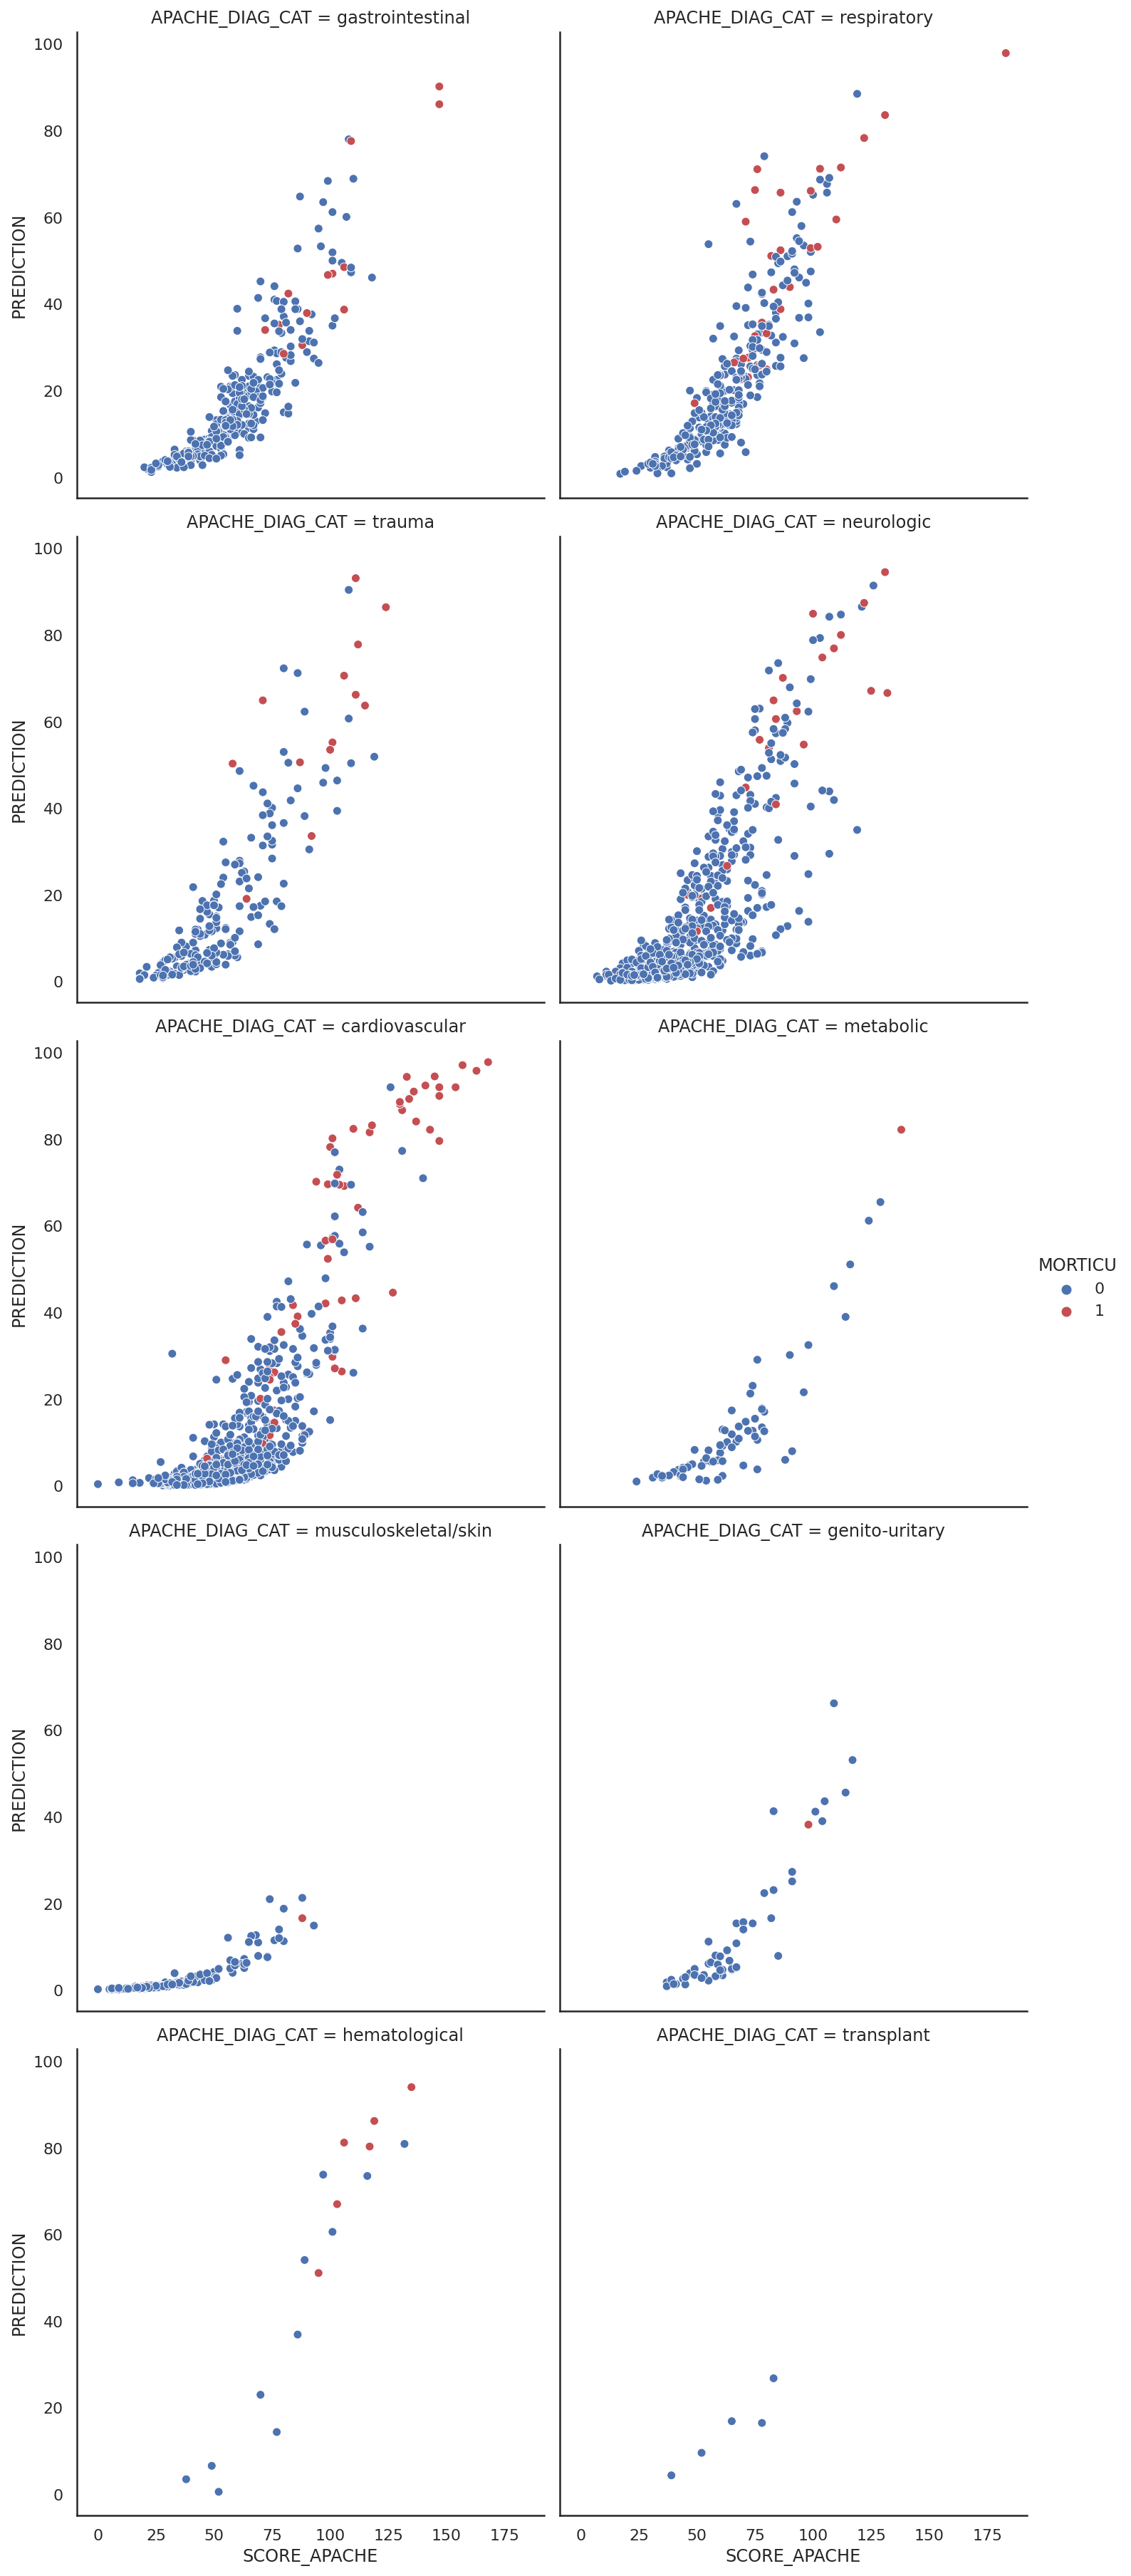

In [ ]:
sns.relplot(x="SCORE_APACHE", y="PREDICTION",col='APACHE_DIAG_CAT',col_wrap=2,hue="MORTICU",palette=["b", "r"],data=data);

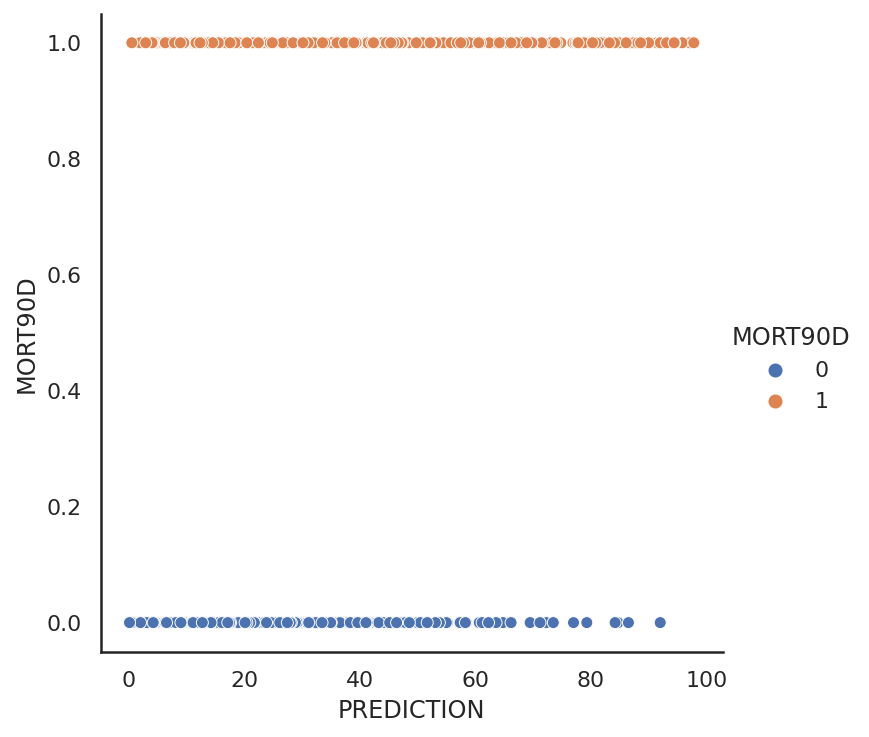

In [ ]:
sns.relplot(x="PREDICTION", y="MORT90D",hue="MORT90D",data=data);

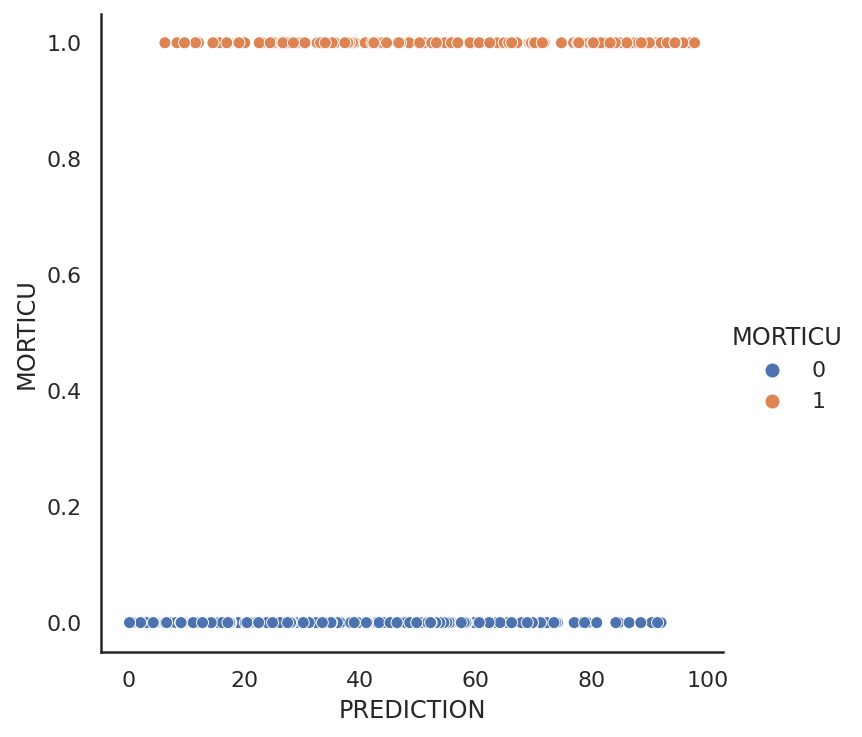

In [ ]:
sns.relplot(x="PREDICTION", y="MORTICU",hue="MORTICU",data=data);

In [ ]:
feature_cols = ['PREDICTION']
X = data[feature_cols] # Features
y = data.MORT90D # Target variable

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
data.head()

,ZHID,PATID,VISITID,UpdateTimestamp,MORTICU,MORT90D,DATETIME_START,DATETIME_END,AGE,ADMTYPE,ADMSOURCE,PRE_ICU_LOS,CABG,NB_GRAFTS,CHRON_DIALYSIS,CIRRHOSIS,NEOPLASM_METAST,HEPATIC,HEM_MALIGN,LYMPHOMA,LEUKEMIA,MULTIPLE_MYELOMA,IMM_INSUF,MECH_VENTIL_24,EYE_LOW,MOTOR_LOW,VERBAL_LOW,EMV,HEARTRATE_MIN,HEARTRATE_MAX,RESPRATE_MIN,RESPRATE_MAX,MEANBL_MIN,MEANBL_MAX,TEMP_MIN,TEMP_MAX,ALBUM_MIN,ALBUM_MAX,CREAT_MIN,CREAT_MAX,GLUC_MIN,GLUC_MAX,HT_MIN,HT_MAX,SODIUM_MIN,SODIUM_MAX,WBC_MIN,WBC_MAX,AADO2_MIN,BILI_MAX,FIO2_MAX,PAO2_MIN,PACO2_MIN,PACO2_MAX,PAO2_FIO2_MIN,PH_MIN,PH_MAX,UREA_MAX,URINE,APACHE_DIAG_NR,APACHE_DIAG_CAT,SCORE_APACHE,PREDICTION,DATETIME_DIFF
0,BELG-ZOL,601049,12892358,2020-07-03 14:17:00,0,0,2019-01-01 05:07:00,2019-01-01 11:20:00,53,2,2.0,0.11,0,0.0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,67,76.0,12.0,23.0,62,103.0,35.6,36.9,NaN,NaN,0.64,0.64,153.0,153.0,46.0,46.0,137.0,140.0,15.5,15.5,-77.4,0.9,True,181.0,36.9,36.9,861.9,7.47,7.47,13.0,2.5,299,gastrointestinal,23,1.2,0 days 06:13:00
1,BELG-ZOL,86824,12874187,2020-07-03 14:17:00,0,1,2019-01-01 12:59:00,2019-01-04 14:22:00,68,1,3.0,12.90,0,0.0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,95,148.0,14.0,27.0,62,91.0,36.9,39.9,31.73,31.73,1.09,1.46,93.0,214.0,21.0,29.0,137.0,144.0,7.1,15.1,NaN,1.9,False,54.4,34.8,47.0,NaN,7.48,7.53,113.0,1.9,168,respiratory,78,42.3,3 days 01:23:00
2,BELG-ZOL,566517,12892419,2020-07-03 14:17:00,0,0,2019-01-01 18:38:00,2019-01-02 11:36:00,79,2,2.0,0.29,0,0.0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,66,100.0,12.0,25.0,79,147.0,36.9,38.2,31.82,32.59,1.63,2.06,160.0,183.0,26.0,39.0,133.0,137.0,9.9,13.2,NaN,0.5,False,65.2,37.9,40.6,NaN,7.32,7.36,63.0,0.6,438,trauma,70,17.5,0 days 16:58:00
3,BELG-ZOL,860417,12892498,2020-07-03 14:17:00,0,1,2019-01-01 22:35:00,2019-01-03 14:19:00,65,2,3.0,0.12,0,0.0,0,0,0,0,0,0,0,0,0,1,4,6,4,14,74,101.0,9.0,20.0,86,213.0,36.4,37.2,NaN,NaN,0.67,1.02,121.0,153.0,34.0,36.0,140.0,143.0,6.8,8.3,NaN,0.3,False,65.5,34.9,40.5,NaN,7.39,7.45,27.0,1.9,366,neurologic,46,23.4,1 days 15:44:00
4,BELG-ZOL,105732,12892510,2020-07-03 14:17:00,0,0,2019-01-02 02:55:00,2019-01-08 12:23:00,36,2,3.0,0.20,0,0.0,0,0,0,0,0,0,0,0,0,1,4,6,5,15,72,112.0,8.0,18.0,60,92.0,36.1,37.9,17.19,17.19,0.90,1.13,111.0,204.0,32.0,33.0,126.0,133.0,15.4,26.2,NaN,0.8,False,106.0,40.8,49.8,NaN,7.35,7.47,91.0,1.5,300,gastrointestinal,64,20.0,6 days 09:28:00


In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[622,   8],
       [ 41,  33]])

In [ ]:
from sklearn.metrics import classification_report as rep
print(rep(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       630
           1       0.80      0.45      0.57        74

    accuracy                           0.93       704
   macro avg       0.87      0.72      0.77       704
weighted avg       0.92      0.93      0.92       704



In [ ]:
# Predicting over the Train
train_predict = logreg.predict_proba(X_train)
train_predict

array([[0.97377606, 0.02622394],
       [0.9635628 , 0.0364372 ],
       [0.97668816, 0.02331184],
       ...,
       [0.96985655, 0.03014345],
       [0.92813627, 0.07186373],
       [0.87182612, 0.12817388]])

In [ ]:
train_preds = train_predict[:,1]
train_preds

array([0.02622394, 0.0364372 , 0.02331184, ..., 0.03014345, 0.07186373,
       0.12817388])

In [ ]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

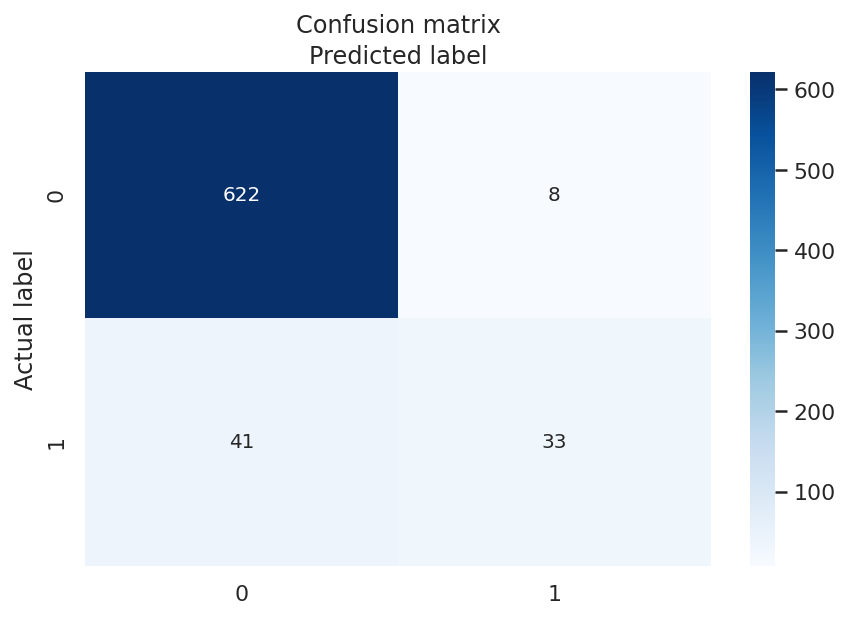

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9303977272727273
Precision: 0.8048780487804879
Recall: 0.44594594594594594


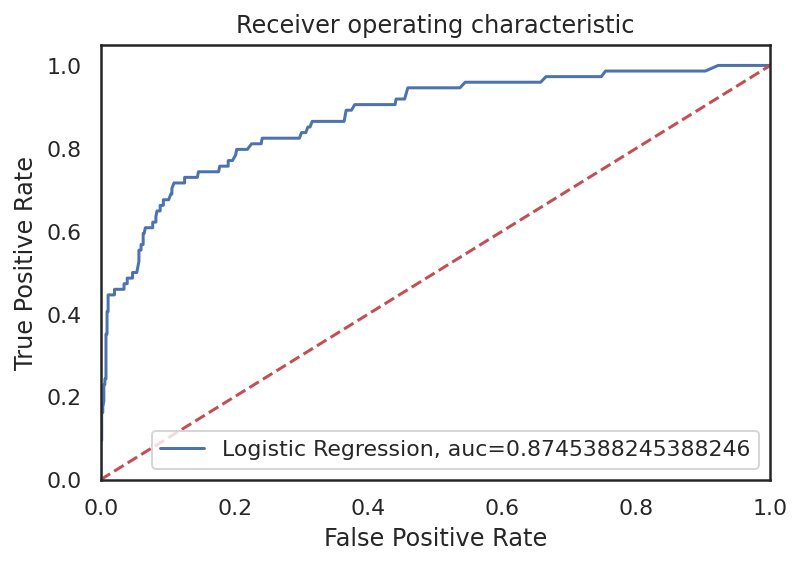

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig('Log_ROC')
plt.figure()
plt.show()

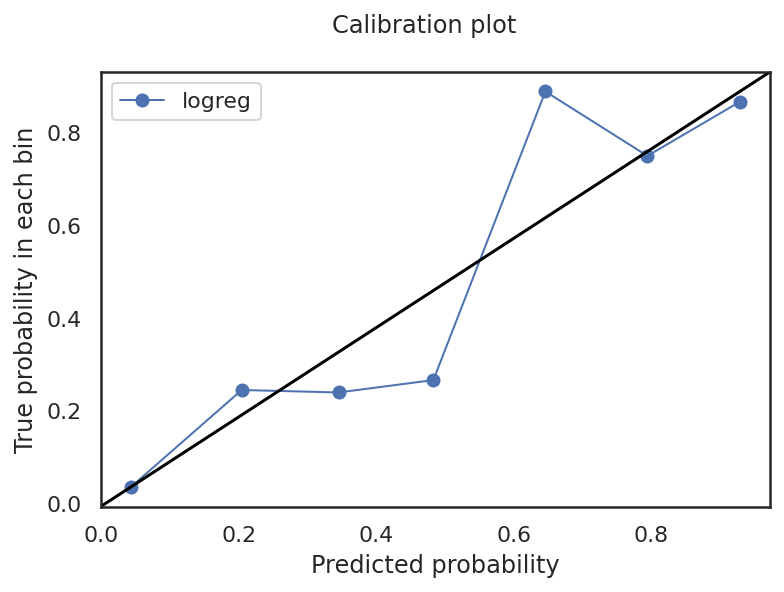

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_test, y_pred_proba, n_bins=7)
fig, ax = plt.subplots()

plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

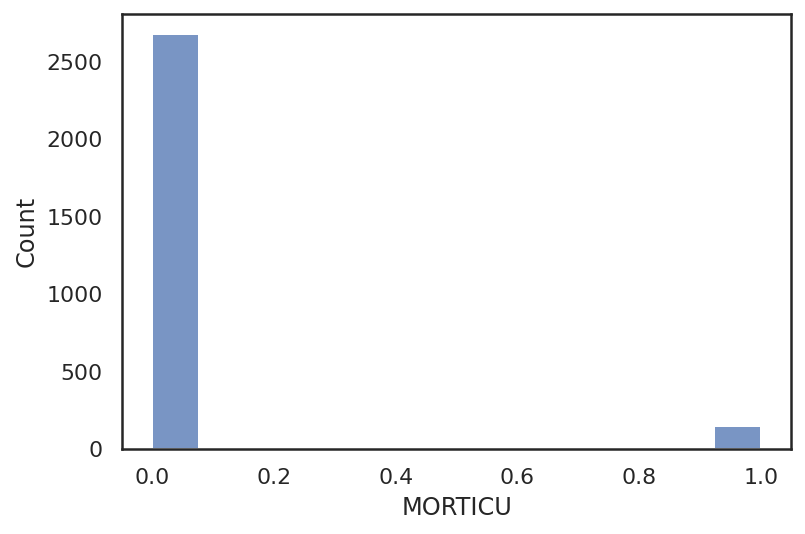

In [ ]:
sns.histplot(data['MORTICU'])



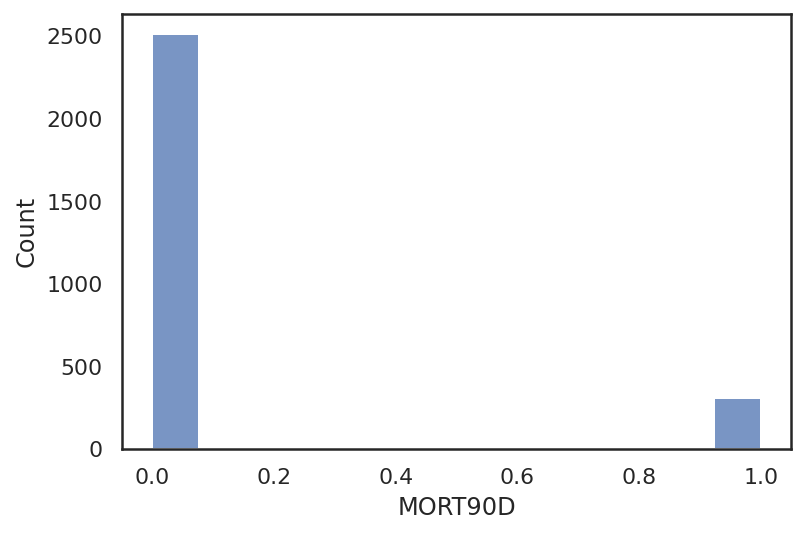

In [ ]:
sns.histplot(data['MORT90D'])